In [1]:
import numpy as np
from DSSStartup import DSSStartup
from setInfo import *
from getInfo import *
import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd
import time
from replay_buffer import ReplayBuffer
import numpy as np
#######################################################
#######################################################
###Global variable initialization and error checking###
#######################################################
#######################################################
Sbase=1
LoadScalingFactor = 1.5
GenerationScalingFactor = 5 
SlackBusVoltage = 1.04 
NoiseMultiplyer= 0

#Set simulation analysis period - the simulation is from StartTime to EndTime
StartTime = 42900
EndTime = 44000
EndTime += 1 # creating a list, last element does not count, so we increase EndTime by 1
#Set hack parameters
TimeStepOfHack = 300
PercentHacked = np.array([0,0,0,0,0, 0,0,.5,0,0,.5,.5,.5,.5,.5,0,0,.5, 0,0,0,0,0,0,0,0,0,0,0,0,0])
#PercentHacked = np.array([0,0,0,0,0, .1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1, 0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set initial VBP parameters for uncompromised inverters
VQ_start = 1.01
VQ_end = 1.03
VP_start = 1.03
VP_end = 1.05

#Set delays for each node

Delay_VoltageSampling = np.array([0,0,0,0,0, 10,10,10,10,10,10,10,10,10,10,10,10,10, 0,0,0,0,0,0,0,0,0,0,0,0,0]) 
Delay_VBPCurveShift =   np.array([0,0,0,0,0, 60,60,60,60,60,60,60,60,60,60,60,60,60, 0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set observer voltage threshold
ThreshHold_vqvp = 0.25
power_factor=0.9
pf_converted=tan(acos(power_factor))
Number_of_Inverters = 13 #even feeder is 34Bus, we only have 13 inverters


#Error checking of the global variable -- TODO: add error handling here!
if EndTime < StartTime or EndTime < 0 or StartTime < 0:
    print('Setup Simulation Times Appropriately.')
if NoiseMultiplyer < 0:
    print('Setup Noise Multiplyer Correctly.')
    
DSSStart = DSSStartup()
DSSText =DSSStart['dsstext']
DSSSolution = DSSStart['dsssolution']
DSSCircuit = DSSStart['dsscircuit']
DSSObj = DSSStart['dssobj']
DSSMon = DSSCircuit.Monitors
DSSText.command = 'Compile C:\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
DSSSolution.Solve()
if not DSSSolution.Converged:
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    DSSMon.ResetAll
    setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=DSSCircuit.Loads.Count
    AllLoadNames=DSSCircuit.Loads.AllNames
    print('OpenDSS Model Compliation Done.')

#######################################################
#######################################################
####         Load data from file                    ###
#######################################################
#######################################################

#Retrieving the data from the load profile
TimeResolutionOfData=10 #resolution in minute
#Get the data from the Testpvnum folder
#Provide Your Directory - move testpvnum10 from github to drive C: 
FileDirectoryBase ='C:\\feeders\\testpvnum10\\';
QSTS_Time = list(range(1441)) #This can be changed based on the available data - for example, 1440 timesteps
QSTS_Data = np.zeros((len(QSTS_Time) ,4,TotalLoads)) #4 columns as there are four columns of data available in the .mat file

for node in range(TotalLoads):
    #This is created manually according to the naming of the folder
    FileDirectoryExtension = 'node_' + str(node+1) + '_pv_' +str(TimeResolutionOfData) + '_minute.csv'
    #The total file directory
    FileName = FileDirectoryBase + FileDirectoryExtension
    #Load the file
    MatFile = np.genfromtxt(FileName, delimiter=',')    
    QSTS_Data[:,:,node] = MatFile #Putting the loads to appropriate nodes according to the loadlist
    
Generation = QSTS_Data[:,1,:]*GenerationScalingFactor #solar generation
Load = QSTS_Data[:,3,:]*LoadScalingFactor #load demand
Generation = np.squeeze(Generation)/Sbase  #To convert to per unit, it should not be multiplied by 100
Load = np.squeeze(Load)/Sbase
print('Reading Data for Pecan Street is done.')

############################################################
############################################################
#### Interpolate to change data from minutes to seconds ####
############################################################
############################################################

from scipy.interpolate import interp1d

print('Starting Interpolation...')

#interpolation for the whole period...
Time = list(range(StartTime,EndTime))
TotalTimeSteps = len(Time)
LoadSeconds = np.empty([3600*24, TotalLoads])
GenerationSeconds = np.empty([3600*24, TotalLoads])
# Interpolate to get minutes to seconds
for node in range(TotalLoads): # i is node
    t_seconds = np.linspace(1,len(Load[:,node]), int(3600*24/1))
    f = interp1d(range(len(Load[:,node])), Load[:,node], kind='cubic', fill_value="extrapolate")
    LoadSeconds[:,node] = f(t_seconds) #spline method in matlab equal to Cubic Spline -> cubic
    
    f = interp1d(range(len(Generation[:,node])), Generation[:,node], kind='cubic', fill_value="extrapolate")
    GenerationSeconds[:,node]= f(t_seconds)

# Initialization
# then we take out only the window we want...
LoadSeconds = LoadSeconds[StartTime:EndTime,:]
GenerationSeconds = GenerationSeconds[StartTime:EndTime,:]
Load = LoadSeconds
Generation = GenerationSeconds
Origin_Load = LoadSeconds
Origin_Generation = GenerationSeconds

Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
Reading Data for Pecan Street is done.
Starting Interpolation...


In [2]:
############################################################
############################################################
#### Function for simulation################################
############################################################
############################################################

def inverter_qp_injection(counter, Vk, Vkm1, gammakm1, solar_irr, VBP, Sbar, dv, T=1, lpf=1):
    pk = 0
    qk = 0
    c = 0
    q_avail = 0

    solar_range = 5

    Vmagk = abs(Vk)
    Vmagkm1 = abs(Vkm1)
    gammakcalc = (T*lpf*(Vmagk + Vmagkm1) - (T*lpf - 2)*gammakm1)/(2 + T*lpf)

    if counter % dv == 0:
        gammakused = gammakcalc
    else :
        gammakused = gammakm1

    if solar_irr < solar_range:
        pk = 0
        qk = 0
    elif solar_irr >= solar_range:
        if gammakused <= VBP[2]:
            pk = -solar_irr
            q_avail = (Sbar**2 - pk**2)**(1/2)
            if gammakused <= VBP[0]:
                qk = 0
            elif gammakused > VBP[0] and gammakused <= VBP[1]:
                c = q_avail/(VBP[1] - VBP[0])
                qk = c*(gammakused - VBP[0])
            else:
                qk = q_avail
        elif gammakused > VBP[2] and gammakused < VBP[3]:
            d = -solar_irr/(VBP[3] - VBP[2])
            pk = -(d*(gammakused - VBP[2]) + solar_irr)
            qk = (Sbar**2 - pk**2)**(1/2)
        elif gammakused >= VBP[3]:
            qk = Sbar
            pk = 0
    return qk,pk, gammakused
    
def voltage_observer(vk, vkm1, psikm1, epsilonkm1, ykm1, f_hp=1, f_lp=0.1, gain=1e5, T=1):
    Vmagk = abs(vk)
    Vmagkm1 = abs(vkm1)
    psik = (Vmagk - Vmagkm1 - (f_hp*T/2-1)*psikm1)/(1+f_hp*T/2)
    epsilonk = gain*(psik**2)
    yk = (T*f_lp*(epsilonk + epsilonkm1) - (T*f_lp - 2)*ykm1)/(2 + T*f_lp)
    return yk, psik, epsilonk

def adaptive_control(delay, vk, vkmdelay, ukmdelay, thresh, yk):
    if (yk > thresh):
        uk = delay/2*k * ( vk**2 + vkmdelay**2 ) + ukmdelay
    else:
        uk = ukmdelay
    return uk

In [3]:
#support function
def processing_state(V, G, L):
    state = np.array([V, G, L]).T
    result = np.zeros((60,3))
    result[:state.shape[0],:state.shape[1]] = state #padding with zeros
    state = result.copy()
    return state

In [4]:
#this is the agent
import tensorflow as tf
EPS = 1e-6

def build_graph(inputs, layer_sizes):
    if type(inputs) is tf.Tensor:
        inputs = [inputs]
    
    with tf.variable_scope('layer0'):
        state = inputs[0]
        gru_cell = tf.contrib.rnn.GRUCell(num_units=32)
        outputs, states = tf.nn.dynamic_rnn(gru_cell, state, dtype=tf.float32)
        state0 = tf.layers.dense(states, 30)
        if len(inputs) != 1:
            action = inputs[1]
            action0 = tf.layers.dense(action, 30)
            layer = action0 + state0
        else: 
            layer = state0
        layer = tf.nn.relu(layer)
    
    for i_layer, size in enumerate(layer_sizes, 1):
        with tf.variable_scope('layer{0}'.format(i_layer)):
            layer = tf.layers.dense(layer, size)
            if i_layer < len(layer_sizes) - 1:
                layer = tf.nn.relu(layer)
    
    #layer = tf.squeeze(layer)
    
    return layer

class NNFunction():
    def __init__(self, name, input_pls, hidden_layer_sizes):
        self._name = name
        self._input_pls = input_pls
        self._layer_sizes = list(hidden_layer_sizes) + [1]
        self._output_t = self.get_output_for(*self._input_pls)
    def get_output_for(self, *inputs, reuse=False):
        with tf.variable_scope(self._name, reuse=reuse):
            value_t = build_graph(inputs=inputs, layer_sizes=self._layer_sizes)
        return value_t
    
    def get_params_internal(self):

        scope = tf.get_variable_scope().name
        scope += '/' + self._name + '/' if len(scope) else self._name + '/'
        return tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope
        )
    
class NNVFunction(NNFunction):
    def __init__(self, hidden_layer_sizes=(30, 30), name='vf'):
        self._Do = [60,3]
        self._obs_pl = tf.placeholder(tf.float32, shape=[None] + self._Do, name='observation')
        super(NNVFunction, self).__init__(name, (self._obs_pl,), hidden_layer_sizes)


class NNQFunction(NNFunction):
    def __init__(self, hidden_layer_sizes=(30, 30), name='qf'):
        self._Da = 4
        self._Do = [60,3]
        self._obs_pl = tf.placeholder(tf.float32, shape=[None]+ self._Do, name='observation')
        self._action_pl = tf.placeholder(tf.float32, shape=[None, self._Da], name='action')
        super(NNQFunction, self).__init__(name, (self._obs_pl, self._action_pl), hidden_layer_sizes)

#############################################################        
class Normal():
    def __init__(self, hidden_layer_sizes, D, obs, reparameterize, reg):
        self._layer_sizes = list(hidden_layer_sizes) + [2*D]
        self._reparameterize = reparameterize
        self._reg = reg
        self._obs = obs
        self._D = D
        self._create_graph()
    def _create_graph(self, LOG_SIG_CAP_MIN=-200, LOG_SIG_CAP_MAX=-0.5):
        Dx = self._D
        mu_and_logsig_t = build_graph(inputs=self._obs, layer_sizes=self._layer_sizes)
        self._mu_t = mu_and_logsig_t[..., :Dx]
        self._log_sig_t = tf.clip_by_value(mu_and_logsig_t[..., Dx:], LOG_SIG_CAP_MIN, LOG_SIG_CAP_MAX)

        # Tensorflow's multivariate normal distribution supports reparameterization
        ds = tf.contrib.distributions
        dist = ds.MultivariateNormalDiag(loc=self._mu_t, scale_diag=tf.exp(self._log_sig_t))
        x_t = dist.sample()
        if not self._reparameterize:
            x_t = tf.stop_gradient(x_t)
        log_pi_t = dist.log_prob(x_t)

        self._dist = dist
        self._x_t = x_t
        self._log_pi_t = log_pi_t
        
        reg_loss_t = self._reg * 0.5 * tf.reduce_mean(self._log_sig_t ** 2)
        reg_loss_t += self._reg * 0.5 * tf.reduce_mean(self._mu_t ** 2)
        self._reg_loss_t = reg_loss_t
    
    @property
    def log_p_t(self):
        return self._log_pi_t

    @property
    def reg_loss_t(self):
        return self._reg_loss_t

    @property
    def x_t(self):
        return self._x_t

    @property
    def mu_t(self):
        return self._mu_t

    @property
    def log_sig_t(self):
        return self._log_sig_t
    
class GaussianPolicy():
    def __init__(self, hidden_layer_sizes=(30,30), reparameterize=False, name='policy', squash=True):
        self._name = name
        self._Do = [60,3]
        self._Da = 4
        self._obs_pl = tf.placeholder(tf.float32, shape=[None] + self._Do, name='observation')
        self._action_pl = tf.placeholder(tf.float32, shape=[None, self._Da], name='action')
        self._layer_sizes = hidden_layer_sizes
        self._squash = squash
        self._reparameterize = reparameterize
    def actions_for(self, observations, reuse=tf.AUTO_REUSE, with_log_pis = True):
        name = self._name
        with tf.variable_scope(name, reuse=reuse):
            distribution = Normal(hidden_layer_sizes = self._layer_sizes, D = self._Da, obs=(observations,), 
                                 reparameterize=self._reparameterize, reg=True)
        
        raw_actions = distribution.x_t
        actions = tf.tanh(raw_actions) if self._squash else raw_actions
        
        if with_log_pis:
            log_pis = distribution.log_p_t
            if self._squash:
                log_pis -= self._squash_correction(raw_actions)
            return actions, log_pis
        
        return actions    
    
    def get_params_internal(self):

        scope = tf.get_variable_scope().name
        scope += '/' + self._name + '/' if len(scope) else self._name + '/'
        return tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope
        )
    
    def _squash_correction(self, actions):
        if not self._squash: return 0
        return tf.reduce_sum(tf.log(1 - tf.tanh(actions) ** 2 + EPS), axis=1)
    
    def name(self):
        return self._name

class agent():
    def __init__(self, sess, observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph, name='agent'):
        self._observations_ph = observations_ph
        self._next_observations_ph = next_observations_ph
        self._rewards_ph = rewards_ph
        self._actions_ph= actions_ph
        self._terminals_ph = terminals_ph
        
        self._discount = 0.99
        self._tau = 0.01
        
        self._qf_lr = 0.1
        self._vf_lr = 0.1
        self._policy_lr = 0.01
        self._action_prior = 'Normal'
        self._reparameterize = False
        self._sess = sess
        self._training_ops = []
        with tf.variable_scope(name):
            self._vf = NNVFunction((30,30))
            self._qf1 = NNQFunction((30,30), 'qf1')
            self._qf2 = NNQFunction((30,30), 'qf2')
            self._policy = GaussianPolicy(hidden_layer_sizes=(30,30), reparameterize=self._reparameterize)
            self._init_critic_update()
            self._init_actor_update()
            self._init_target_ops()
            
        uninit_vars = []
        for var in tf.global_variables():
            try:
                self._sess.run(var)
            except tf.errors.FailedPreconditionError:
                uninit_vars.append(var)
        self._sess.run(tf.variables_initializer(uninit_vars))
        
        self._init_training()
        
    def _init_critic_update(self):
        self._qf1_t = self._qf1.get_output_for(
            self._observations_ph, self._actions_ph, reuse=True)  # N
        self._qf2_t = self._qf2.get_output_for(
            self._observations_ph, self._actions_ph, reuse=True)  # N

        with tf.variable_scope('target'):
            vf_next_target_t = self._vf.get_output_for(self._next_observations_ph)  # N
            self._vf_target_params = self._vf.get_params_internal()

        ys = tf.stop_gradient(
            self._rewards_ph +
            (1 - self._terminals_ph) * self._discount * vf_next_target_t
        )  # N

        self._td_loss1_t = 0.5 * tf.reduce_mean((ys - self._qf1_t)**2)
        self._td_loss2_t = 0.5 * tf.reduce_mean((ys - self._qf2_t)**2)

        qf1_train_op = tf.train.AdamOptimizer(self._qf_lr).minimize(
            loss=self._td_loss1_t,
            var_list=self._qf1.get_params_internal()
        )
        qf2_train_op = tf.train.AdamOptimizer(self._qf_lr).minimize(
            loss=self._td_loss2_t,
            var_list=self._qf2.get_params_internal()
        )

        self._training_ops.append(qf1_train_op)
        self._training_ops.append(qf2_train_op)

    def _init_actor_update(self):
        actions, log_pi = self._policy.actions_for(observations=self._observations_ph,
                                                   with_log_pis=True)

        self._vf_t = self._vf.get_output_for(self._observations_ph, reuse=True)  # N
        self._vf_params = self._vf.get_params_internal()

        policy_prior_log_probs = 0.0
        if self._action_prior == 'normal':
            D_s = actions.shape.as_list()[-1]
            policy_prior = tf.contrib.distributions.MultivariateNormalDiag(
                loc=tf.zeros(D_s), scale_diag=tf.ones(D_s))
            policy_prior_log_probs = policy_prior.log_prob(actions)
        elif self._action_prior == 'uniform':
            policy_prior_log_probs = 0.0

        log_target1 = self._qf1.get_output_for(
            self._observations_ph, actions, reuse=True)  # N
        log_target2 = self._qf2.get_output_for(
            self._observations_ph, actions, reuse=True)  # N
        min_log_target = tf.minimum(log_target1, log_target2)

        if self._reparameterize:
            policy_kl_loss = tf.reduce_mean(log_pi - log_target1)
        else:
            policy_kl_loss = tf.reduce_mean(log_pi * tf.stop_gradient(
                log_pi - log_target1 + self._vf_t - policy_prior_log_probs))

        policy_regularization_losses = tf.get_collection(
            tf.GraphKeys.REGULARIZATION_LOSSES,
            scope=self._policy.name)
        policy_regularization_loss = tf.reduce_sum(
            policy_regularization_losses)

        policy_loss = (policy_kl_loss
                       + policy_regularization_loss)

        # We update the vf towards the min of two Q-functions in order to
        # reduce overestimation bias from function approximation error.
        self._vf_loss_t = 0.5 * tf.reduce_mean((
          self._vf_t
          - tf.stop_gradient(min_log_target - log_pi + policy_prior_log_probs)
        )**2)

        policy_train_op = tf.train.AdamOptimizer(self._policy_lr).minimize(
            loss=policy_loss,
            var_list=self._policy.get_params_internal()
        )

        vf_train_op = tf.train.AdamOptimizer(self._vf_lr).minimize(
            loss=self._vf_loss_t,
            var_list=self._vf_params
        )

        self._training_ops.append(policy_train_op)
        self._training_ops.append(vf_train_op)        
        self._action = actions
        
    def _init_target_ops(self):
        """Create tensorflow operations for updating target value function."""

        source_params = self._vf_params
        target_params = self._vf_target_params

        self._target_ops = [
            tf.assign(target, (1 - self._tau) * target + self._tau * source)
            for target, source in zip(target_params, source_params)
        ]

    def _init_training(self):
        self._sess.run(self._target_ops)

    def do_training(self, batch):
        """Runs the operations for updating training and target ops."""

        feed_dict = self._get_feed_dict(batch)
        self._sess.run(self._training_ops, feed_dict)
        self._sess.run(self._target_ops)

    def _get_feed_dict(self, batch):
        """Construct TensorFlow feed_dict from sample batch."""

        feed_dict = {
            self._observations_ph: batch['observations'],
            self._actions_ph: batch['actions'],
            self._next_observations_ph: batch['next_observations'],
            self._rewards_ph: batch['rewards'],
            self._terminals_ph: batch['terminals'],
        }
        return feed_dict
   
    def action_respond(self, obs):
        action = self._action
        a = self._sess.run([action], feed_dict={observations_ph: obs})[0][0]
        return a
    
def init_placeholder():
    observations_ph = tf.placeholder(tf.float32, shape=(None, 60, 3), name='observation')
    next_observations_ph = tf.placeholder(tf.float32, shape=(None, 60, 3), name='next_observation')
    rewards_ph = tf.placeholder(tf.float32, shape=(None, 1), name='reward')
    actions_ph = tf.placeholder(tf.float32, shape=(None, 4), name='action')
    terminals_ph = tf.placeholder(tf.float32, shape=(None, 1), name='terminal')
    return observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph

D:\Apps\Anacoda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph = init_placeholder()
sess = tf.Session()
agent = agent(sess, observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph)

In [6]:
#testing
batch = {
    'observations': np.random.random_sample((5,60,3)),
    'actions' : np.random.random_sample((5,4)),
    'next_observations': np.random.random_sample((5,60,3)),
    'rewards': np.random.random_sample((5,1)),
    'terminals': np.array([[1],[1],[1],[1],[1]])
    
}
#agent.do_training(batch)

In [7]:
#testing
"""import numpy as np 
policy = GaussianPolicy()
observations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph = init_placeholder()
action = policy.actions_for(observations_ph, with_log_pis = False)
#testing
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    a = sess.run([action], feed_dict={observations_ph: np.random.random_sample((5,60,3))})[0]
    print(a)
    """

'import numpy as np \npolicy = GaussianPolicy()\nobservations_ph, next_observations_ph, rewards_ph, actions_ph, terminals_ph = init_placeholder()\naction = policy.actions_for(observations_ph, with_log_pis = False)\n#testing\ninit = tf.global_variables_initializer()\nwith tf.Session() as sess:\n    init.run()\n    a = sess.run([action], feed_dict={observations_ph: np.random.random_sample((5,60,3))})[0]\n    print(a)\n    '

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.


D:\Apps\Anacoda3\lib\site-packages\ipykernel_launcher.py:249: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


-109467.37583092059
--- 57.0114905834198 seconds ---


D:\Apps\Anacoda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


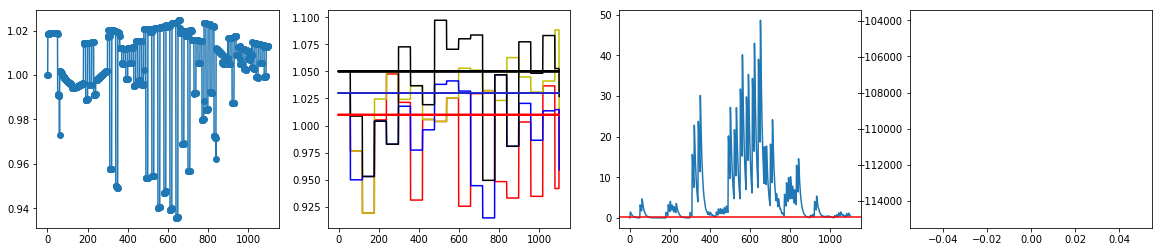

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 2.119330644607544 seconds ---
--- 0.046875 seconds ---
--- 0.060835838317871094 seconds ---
--- 0.04587697982788086 seconds ---
--- 0.04288077354431152 seconds ---
--- 0.04288458824157715 seconds ---
--- 0.044869422912597656 seconds ---
-76629.93348136803
--- 59.8987672328949 seconds ---


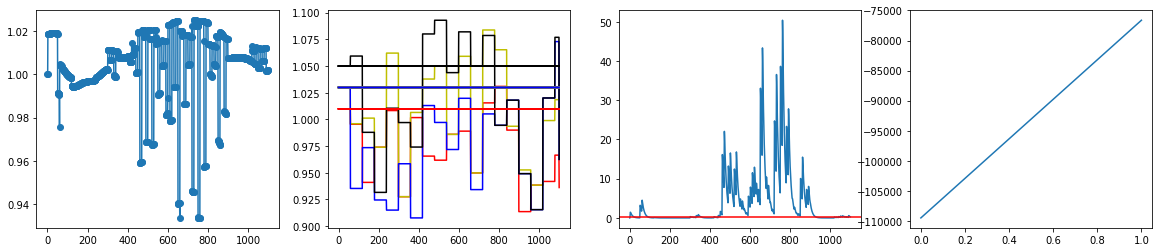

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.0448760986328125 seconds ---
--- 0.042882442474365234 seconds ---
--- 0.05186176300048828 seconds ---
--- 0.04886627197265625 seconds ---
--- 0.039891958236694336 seconds ---
--- 0.04587507247924805 seconds ---
--- 0.0418858528137207 seconds ---
--- 0.04587841033935547 seconds ---
--- 0.05086040496826172 seconds ---
--- 0.04986572265625 seconds ---
--- 0.0418853759765625 seconds ---
--- 0.04188656806945801 seconds ---
--- 0.03889322280883789 seconds ---
--- 0.048867225646972656 seconds ---
--- 0.04188680648803711 seconds ---
--- 0.058840036392211914 seconds ---
--- 0.04088783264160156 seconds ---
--- 0.04089045524597168 seconds ---
--- 0.04886984825134277 seconds ---
-76629.93348136803
--- 56.81301999092102 seconds ---


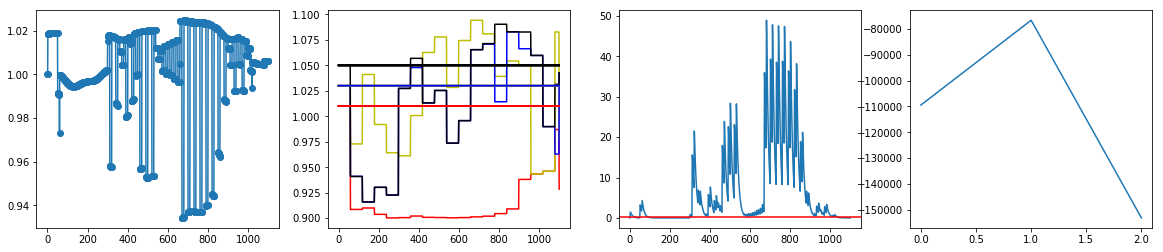

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.0388948917388916 seconds ---
--- 0.04088878631591797 seconds ---
--- 0.04886889457702637 seconds ---
--- 0.03789854049682617 seconds ---
--- 0.0488588809967041 seconds ---
--- 0.04388141632080078 seconds ---
--- 0.04288077354431152 seconds ---
--- 0.05185985565185547 seconds ---
--- 0.058843374252319336 seconds ---
--- 0.046875715255737305 seconds ---
--- 0.04487872123718262 seconds ---
--- 0.04089045524597168 seconds ---
--- 0.038895606994628906 seconds ---
--- 0.042891502380371094 seconds ---
--- 0.04388236999511719 seconds ---
--- 0.042882680892944336 seconds ---
--- 0.04787135124206543 seconds ---
--- 0.05584573745727539 seconds ---
--- 0.04188704490661621 seconds ---
-76629.93348136803
--- 61.07861113548279 seconds ---


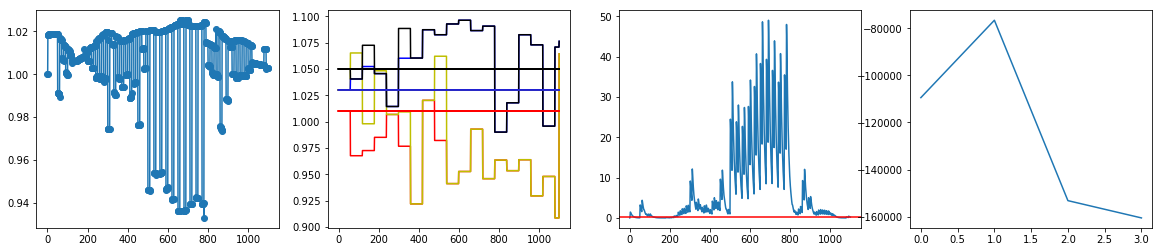

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04886603355407715 seconds ---
--- 0.04088902473449707 seconds ---
--- 0.04188394546508789 seconds ---
--- 0.05585026741027832 seconds ---
--- 0.07080984115600586 seconds ---
--- 0.04288530349731445 seconds ---
--- 0.04288077354431152 seconds ---
--- 0.0418856143951416 seconds ---
--- 0.04288482666015625 seconds ---
--- 0.04388260841369629 seconds ---
--- 0.04188418388366699 seconds ---
--- 0.053856849670410156 seconds ---
--- 0.043881893157958984 seconds ---
--- 0.05584859848022461 seconds ---
--- 0.03789877891540527 seconds ---
--- 0.04985952377319336 seconds ---
--- 0.04587578773498535 seconds ---
--- 0.04288315773010254 seconds ---
--- 0.04587507247924805 seconds ---
-70469.38298086452
--- 59.378159284591675 seconds ---


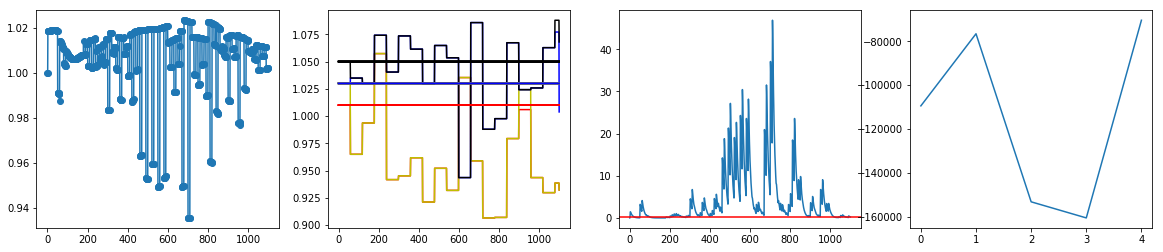

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04088997840881348 seconds ---
--- 0.05086374282836914 seconds ---
--- 0.037897348403930664 seconds ---
--- 0.03789782524108887 seconds ---
--- 0.039893388748168945 seconds ---
--- 0.04288339614868164 seconds ---
--- 0.0388948917388916 seconds ---
--- 0.05285906791687012 seconds ---
--- 0.03889155387878418 seconds ---
--- 0.04288434982299805 seconds ---
--- 0.04986572265625 seconds ---
--- 0.04487872123718262 seconds ---
--- 0.040891408920288086 seconds ---
--- 0.03992152214050293 seconds ---
--- 0.04088950157165527 seconds ---
--- 0.05185985565185547 seconds ---
--- 0.04288482666015625 seconds ---
--- 0.04388117790222168 seconds ---
--- 0.04487967491149902 seconds ---
-52054.99129075892
--- 66.21387195587158 seconds ---


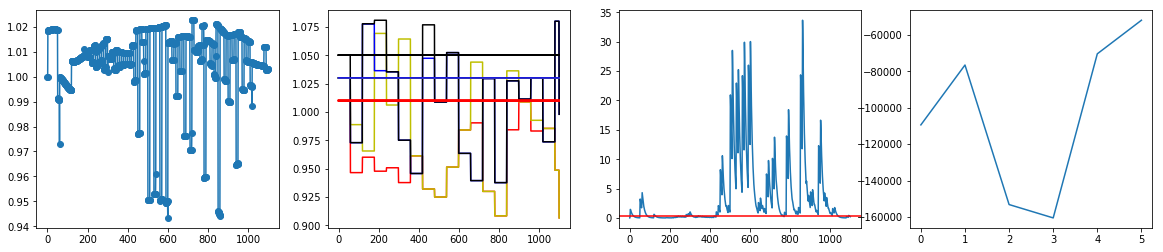

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.041887760162353516 seconds ---
--- 0.03889632225036621 seconds ---
--- 0.05585026741027832 seconds ---
--- 0.0388948917388916 seconds ---
--- 0.07480001449584961 seconds ---
--- 0.0468747615814209 seconds ---
--- 0.045873403549194336 seconds ---
--- 0.040891170501708984 seconds ---
--- 0.05385446548461914 seconds ---
--- 0.041887760162353516 seconds ---
--- 0.042883872985839844 seconds ---
--- 0.04388260841369629 seconds ---
--- 0.04288339614868164 seconds ---
--- 0.04088997840881348 seconds ---
--- 0.039891958236694336 seconds ---
--- 0.050859928131103516 seconds ---
--- 0.0438840389251709 seconds ---
--- 0.0857696533203125 seconds ---
--- 0.049863576889038086 seconds ---
-52054.99129075892
--- 62.550668716430664 seconds ---


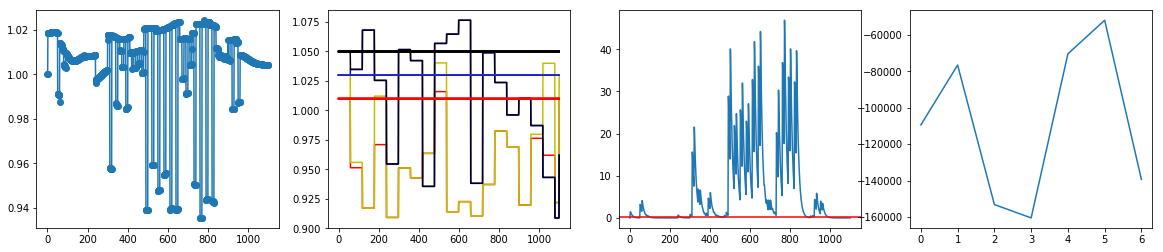

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.038895368576049805 seconds ---
--- 0.04388165473937988 seconds ---
--- 0.043881893157958984 seconds ---
--- 0.05684709548950195 seconds ---
--- 0.0388948917388916 seconds ---
--- 0.04088950157165527 seconds ---
--- 0.04388284683227539 seconds ---
--- 0.04388284683227539 seconds ---
--- 0.049864768981933594 seconds ---
--- 0.03789806365966797 seconds ---
--- 0.04388236999511719 seconds ---
--- 0.04587507247924805 seconds ---
--- 0.05684471130371094 seconds ---
--- 0.04188895225524902 seconds ---
--- 0.05086255073547363 seconds ---
--- 0.04487943649291992 seconds ---
--- 0.04288434982299805 seconds ---
--- 0.03989362716674805 seconds ---
--- 0.04687356948852539 seconds ---
-52054.99129075892
--- 63.81528878211975 seconds ---


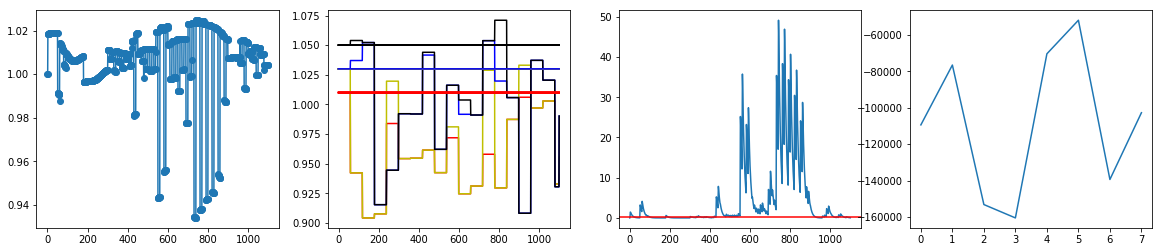

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04188704490661621 seconds ---
--- 0.04288458824157715 seconds ---
--- 0.05285978317260742 seconds ---
--- 0.05086064338684082 seconds ---
--- 0.05485200881958008 seconds ---
--- 0.04587888717651367 seconds ---
--- 0.04487752914428711 seconds ---
--- 0.05186057090759277 seconds ---
--- 0.04088878631591797 seconds ---
--- 0.04787039756774902 seconds ---
--- 0.05585050582885742 seconds ---
--- 0.04487872123718262 seconds ---
--- 0.04787158966064453 seconds ---
--- 0.05086326599121094 seconds ---
--- 0.03989243507385254 seconds ---
--- 0.043883323669433594 seconds ---
--- 0.04288458824157715 seconds ---
--- 0.03989291191101074 seconds ---
--- 0.04288506507873535 seconds ---
-52054.99129075892
--- 60.699623823165894 seconds ---


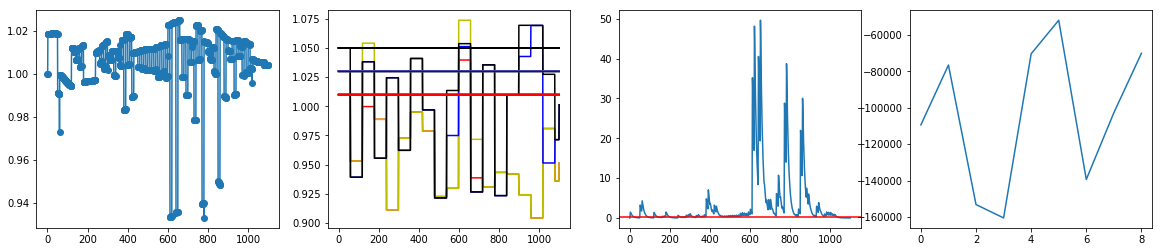

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03889322280883789 seconds ---
--- 0.043880462646484375 seconds ---
--- 0.0388946533203125 seconds ---
--- 0.04687047004699707 seconds ---
--- 0.04089069366455078 seconds ---
--- 0.046872854232788086 seconds ---
--- 0.045876264572143555 seconds ---
--- 0.041884422302246094 seconds ---
--- 0.04587721824645996 seconds ---
--- 0.044878244400024414 seconds ---
--- 0.04188680648803711 seconds ---
--- 0.04188823699951172 seconds ---
--- 0.04587578773498535 seconds ---
--- 0.05485272407531738 seconds ---
--- 0.04388022422790527 seconds ---
--- 0.04487895965576172 seconds ---
--- 0.048865556716918945 seconds ---
--- 0.052857160568237305 seconds ---
--- 0.044885873794555664 seconds ---
-37418.38681076221
--- 57.683690547943115 seconds ---


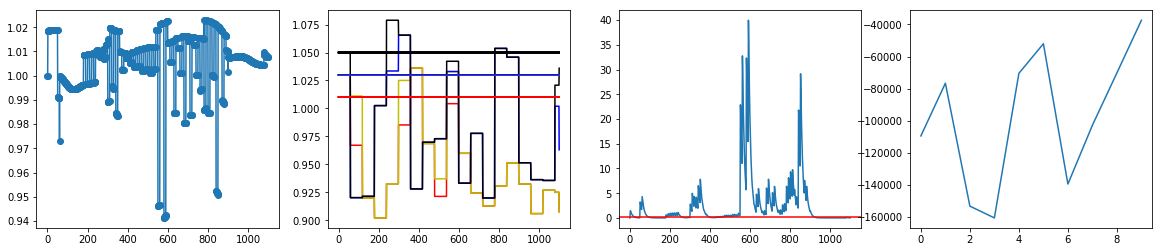

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04188823699951172 seconds ---
--- 0.03889751434326172 seconds ---
--- 0.05585050582885742 seconds ---
--- 0.04786801338195801 seconds ---
--- 0.04787039756774902 seconds ---
--- 0.042882680892944336 seconds ---
--- 0.040891408920288086 seconds ---
--- 0.05185985565185547 seconds ---
--- 0.047872066497802734 seconds ---
--- 0.04089045524597168 seconds ---
--- 0.045877695083618164 seconds ---
--- 0.06181478500366211 seconds ---
--- 0.05485248565673828 seconds ---
--- 0.03590655326843262 seconds ---
--- 0.04387855529785156 seconds ---
--- 0.04188728332519531 seconds ---
--- 0.04188823699951172 seconds ---
--- 0.04587697982788086 seconds ---
--- 0.04088950157165527 seconds ---
-33920.97933345949
--- 62.383119344711304 seconds ---


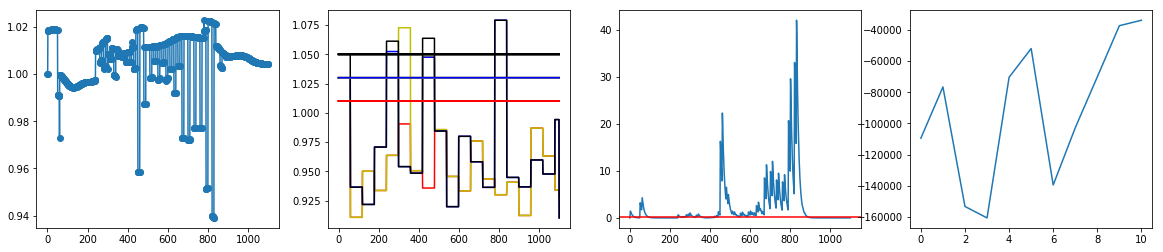

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04089093208312988 seconds ---
--- 0.04188394546508789 seconds ---
--- 0.03797411918640137 seconds ---
--- 0.039890289306640625 seconds ---
--- 0.04487943649291992 seconds ---
--- 0.03989243507385254 seconds ---
--- 0.054853200912475586 seconds ---
--- 0.041887521743774414 seconds ---
--- 0.04088997840881348 seconds ---
--- 0.04089021682739258 seconds ---
--- 0.04188680648803711 seconds ---
--- 0.043881893157958984 seconds ---
--- 0.042884111404418945 seconds ---
--- 0.043881893157958984 seconds ---
--- 0.057845115661621094 seconds ---
--- 0.045873403549194336 seconds ---
--- 0.041887521743774414 seconds ---
--- 0.04288148880004883 seconds ---
--- 0.0388941764831543 seconds ---
-2893.0745682056468
--- 61.334924936294556 seconds ---


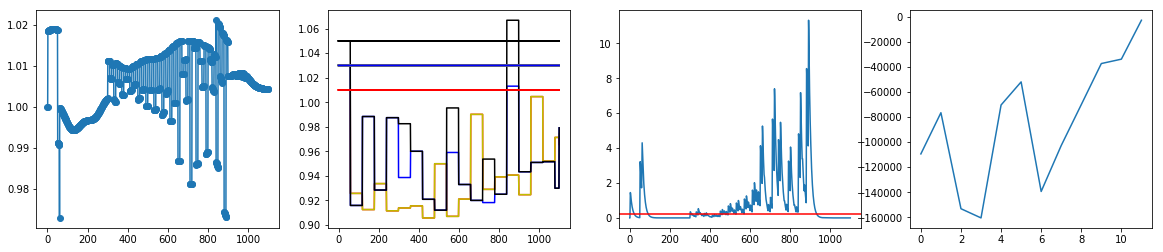

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.044872283935546875 seconds ---
--- 0.05684661865234375 seconds ---
--- 0.046874046325683594 seconds ---
--- 0.05485367774963379 seconds ---
--- 0.04587531089782715 seconds ---
--- 0.04388165473937988 seconds ---
--- 0.0388948917388916 seconds ---
--- 0.04787111282348633 seconds ---
--- 0.0488591194152832 seconds ---
--- 0.044879913330078125 seconds ---
--- 0.05385327339172363 seconds ---
--- 0.044878244400024414 seconds ---
--- 0.06183290481567383 seconds ---
--- 0.07579588890075684 seconds ---
--- 0.041887521743774414 seconds ---
--- 0.03789830207824707 seconds ---
--- 0.04387354850769043 seconds ---
--- 0.04089021682739258 seconds ---
--- 0.045876502990722656 seconds ---
-2893.0745682056468
--- 61.35786175727844 seconds ---


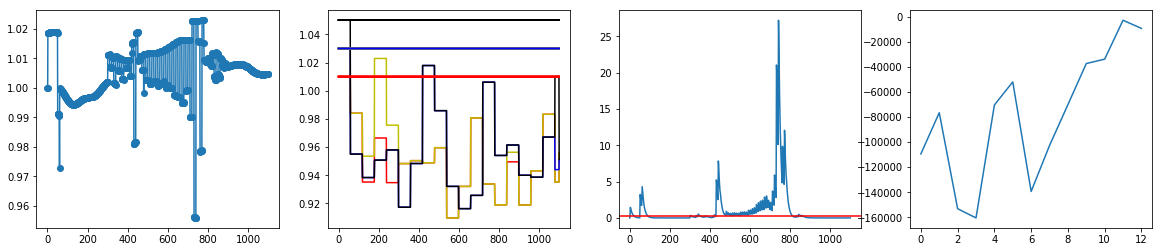

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.0418856143951416 seconds ---
--- 0.03889608383178711 seconds ---
--- 0.042883872985839844 seconds ---
--- 0.05784320831298828 seconds ---
--- 0.0388948917388916 seconds ---
--- 0.045876264572143555 seconds ---
--- 0.05485057830810547 seconds ---
--- 0.04986572265625 seconds ---
--- 0.04388117790222168 seconds ---
--- 0.04687356948852539 seconds ---
--- 0.04487729072570801 seconds ---
--- 0.04088997840881348 seconds ---
--- 0.04388308525085449 seconds ---
--- 0.04288458824157715 seconds ---
--- 0.04986429214477539 seconds ---
--- 0.04188680648803711 seconds ---
--- 0.042883872985839844 seconds ---
--- 0.04387998580932617 seconds ---
--- 0.04288434982299805 seconds ---
-2893.0745682056468
--- 60.413389444351196 seconds ---


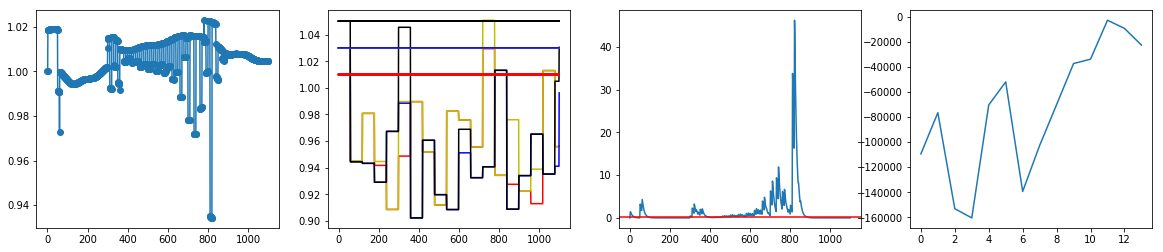

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.043880462646484375 seconds ---
--- 0.03989410400390625 seconds ---
--- 0.0388944149017334 seconds ---
--- 0.04288482666015625 seconds ---
--- 0.0388948917388916 seconds ---
--- 0.0418856143951416 seconds ---
--- 0.0418853759765625 seconds ---
--- 0.039891719818115234 seconds ---
--- 0.046874284744262695 seconds ---
--- 0.0608370304107666 seconds ---
--- 0.04088902473449707 seconds ---
--- 0.039891958236694336 seconds ---
--- 0.04388236999511719 seconds ---
--- 0.041887760162353516 seconds ---
--- 0.044878244400024414 seconds ---
--- 0.03989148139953613 seconds ---
--- 0.05385589599609375 seconds ---
--- 0.03989386558532715 seconds ---
--- 0.050862789154052734 seconds ---
-2893.0745682056468
--- 62.57261276245117 seconds ---


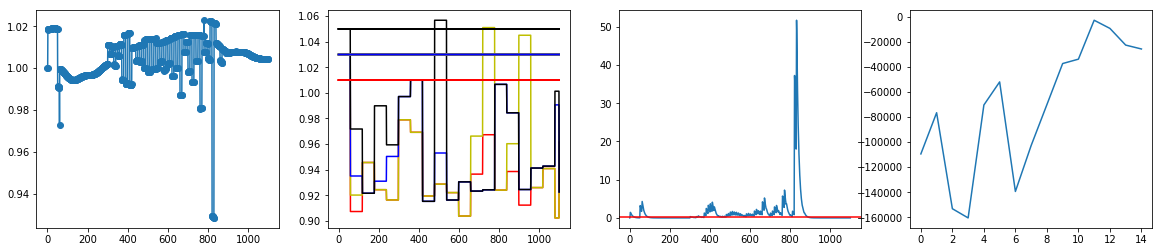

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.044877052307128906 seconds ---
--- 0.03789782524108887 seconds ---
--- 0.044878244400024414 seconds ---
--- 0.0468752384185791 seconds ---
--- 0.0388941764831543 seconds ---
--- 0.05086326599121094 seconds ---
--- 0.04089164733886719 seconds ---
--- 0.04287981986999512 seconds ---
--- 0.041886091232299805 seconds ---
--- 0.038895606994628906 seconds ---
--- 0.04886746406555176 seconds ---
--- 0.04986166954040527 seconds ---
--- 0.05086231231689453 seconds ---
--- 0.047870635986328125 seconds ---
--- 0.05784344673156738 seconds ---
--- 0.0418848991394043 seconds ---
--- 0.040889739990234375 seconds ---
--- 0.04386138916015625 seconds ---
--- 0.04487800598144531 seconds ---
-2893.0745682056468
--- 59.00515699386597 seconds ---


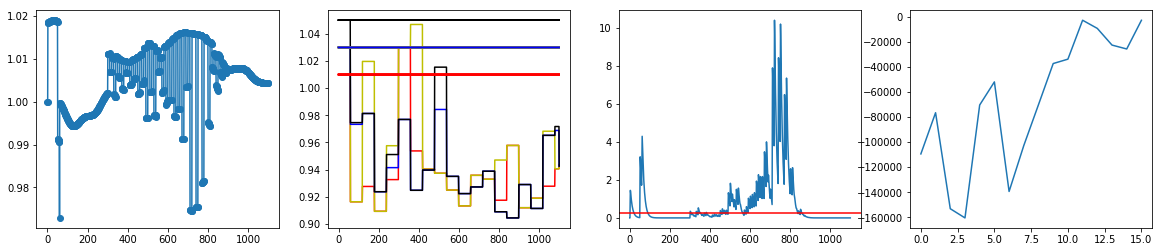

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04288172721862793 seconds ---
--- 0.04188680648803711 seconds ---
--- 0.04886746406555176 seconds ---
--- 0.045876264572143555 seconds ---
--- 0.0388948917388916 seconds ---
--- 0.04188656806945801 seconds ---
--- 0.054854393005371094 seconds ---
--- 0.04188680648803711 seconds ---
--- 0.045876264572143555 seconds ---
--- 0.038895606994628906 seconds ---
--- 0.04487919807434082 seconds ---
--- 0.04388284683227539 seconds ---
--- 0.046874046325683594 seconds ---
--- 0.04387927055358887 seconds ---
--- 0.04387974739074707 seconds ---
--- 0.042885541915893555 seconds ---
--- 0.04288458824157715 seconds ---
--- 0.04288339614868164 seconds ---
--- 0.04188799858093262 seconds ---
-2893.0745682056468
--- 62.00413393974304 seconds ---


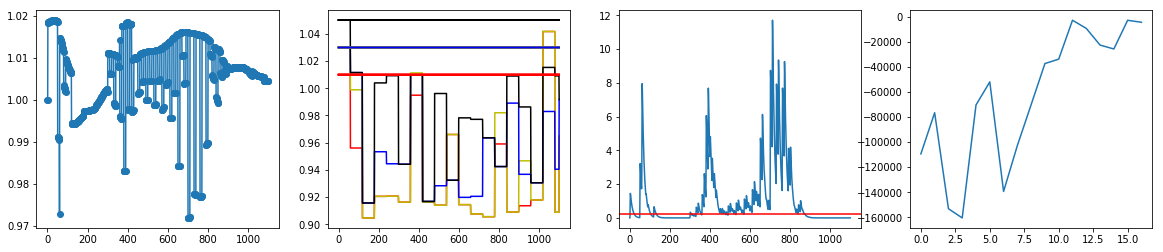

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.039891958236694336 seconds ---
--- 0.05983614921569824 seconds ---
--- 0.04088783264160156 seconds ---
--- 0.0448758602142334 seconds ---
--- 0.05584979057312012 seconds ---
--- 0.042882680892944336 seconds ---
--- 0.049866437911987305 seconds ---
--- 0.04587721824645996 seconds ---
--- 0.038895368576049805 seconds ---
--- 0.04587602615356445 seconds ---
--- 0.046875 seconds ---
--- 0.04188799858093262 seconds ---
--- 0.049866676330566406 seconds ---
--- 0.061834096908569336 seconds ---
--- 0.04089093208312988 seconds ---
--- 0.04188728332519531 seconds ---
--- 0.04487967491149902 seconds ---
--- 0.04886746406555176 seconds ---
--- 0.04288196563720703 seconds ---
-2893.0745682056468
--- 59.24152231216431 seconds ---


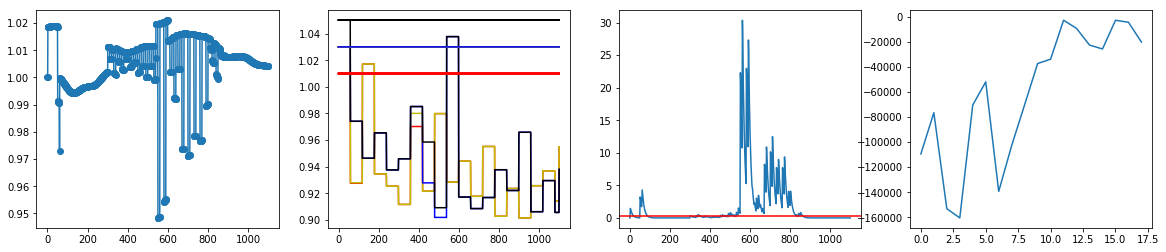

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04986405372619629 seconds ---
--- 0.04587411880493164 seconds ---
--- 0.05086398124694824 seconds ---
--- 0.04787278175354004 seconds ---
--- 0.040888309478759766 seconds ---
--- 0.039891958236694336 seconds ---
--- 0.0468745231628418 seconds ---
--- 0.043881893157958984 seconds ---
--- 0.05485129356384277 seconds ---
--- 0.039893150329589844 seconds ---
--- 0.04787158966064453 seconds ---
--- 0.051860809326171875 seconds ---
--- 0.06582212448120117 seconds ---
--- 0.052857160568237305 seconds ---
--- 0.04388165473937988 seconds ---
--- 0.048868656158447266 seconds ---
--- 0.04088950157165527 seconds ---
--- 0.040891170501708984 seconds ---
--- 0.04188704490661621 seconds ---
-1314.2881846358289
--- 61.21225094795227 seconds ---


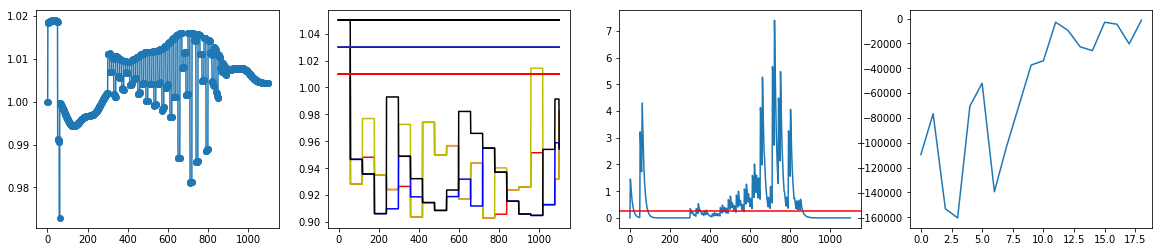

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04288458824157715 seconds ---
--- 0.04786968231201172 seconds ---
--- 0.07579469680786133 seconds ---
--- 0.05884194374084473 seconds ---
--- 0.05485081672668457 seconds ---
--- 0.042885541915893555 seconds ---
--- 0.03689885139465332 seconds ---
--- 0.045876502990722656 seconds ---
--- 0.054853200912475586 seconds ---
--- 0.03889274597167969 seconds ---
--- 0.037899017333984375 seconds ---
--- 0.042883872985839844 seconds ---
--- 0.0468747615814209 seconds ---
--- 0.03889656066894531 seconds ---
--- 0.04188799858093262 seconds ---
--- 0.054854631423950195 seconds ---
--- 0.04886937141418457 seconds ---
--- 0.04088854789733887 seconds ---
--- 0.0418858528137207 seconds ---
-1290.7777886848748
--- 61.14842247962952 seconds ---


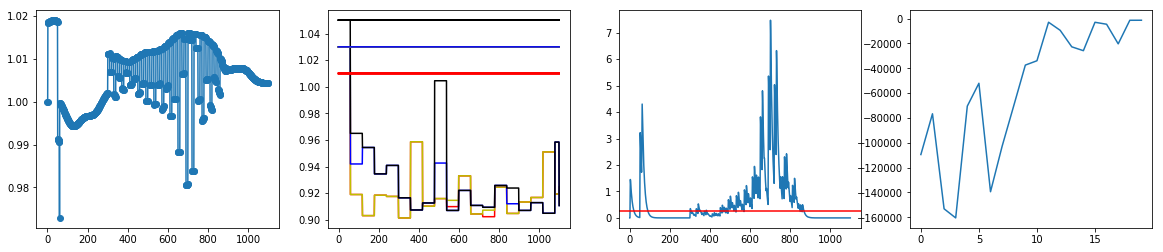

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.044878244400024414 seconds ---
--- 0.042885541915893555 seconds ---
--- 0.04387784004211426 seconds ---
--- 0.041887760162353516 seconds ---
--- 0.043880462646484375 seconds ---
--- 0.04288506507873535 seconds ---
--- 0.043882131576538086 seconds ---
--- 0.044878482818603516 seconds ---
--- 0.041886091232299805 seconds ---
--- 0.04288458824157715 seconds ---
--- 0.048867225646972656 seconds ---
--- 0.042885780334472656 seconds ---
--- 0.04786849021911621 seconds ---
--- 0.042885780334472656 seconds ---
--- 0.03989267349243164 seconds ---
--- 0.05485248565673828 seconds ---
--- 0.057843923568725586 seconds ---
--- 0.05983901023864746 seconds ---
--- 0.0388944149017334 seconds ---
-1290.7777886848748
--- 60.15707325935364 seconds ---


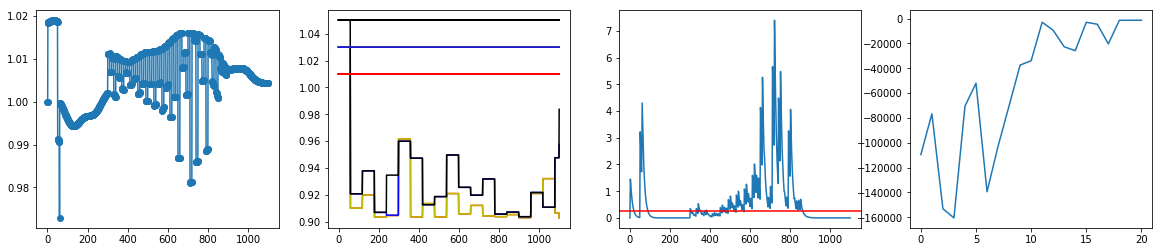

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.042885780334472656 seconds ---
--- 0.03989243507385254 seconds ---
--- 0.04288315773010254 seconds ---
--- 0.03789710998535156 seconds ---
--- 0.03789710998535156 seconds ---
--- 0.04687356948852539 seconds ---
--- 0.03889608383178711 seconds ---
--- 0.048867225646972656 seconds ---
--- 0.05983710289001465 seconds ---
--- 0.04288601875305176 seconds ---
--- 0.04088401794433594 seconds ---
--- 0.0388948917388916 seconds ---
--- 0.04687690734863281 seconds ---
--- 0.04288458824157715 seconds ---
--- 0.046874046325683594 seconds ---
--- 0.04288315773010254 seconds ---
--- 0.040886878967285156 seconds ---
--- 0.036901235580444336 seconds ---
--- 0.0388948917388916 seconds ---
-1290.7777886848748
--- 59.15774846076965 seconds ---


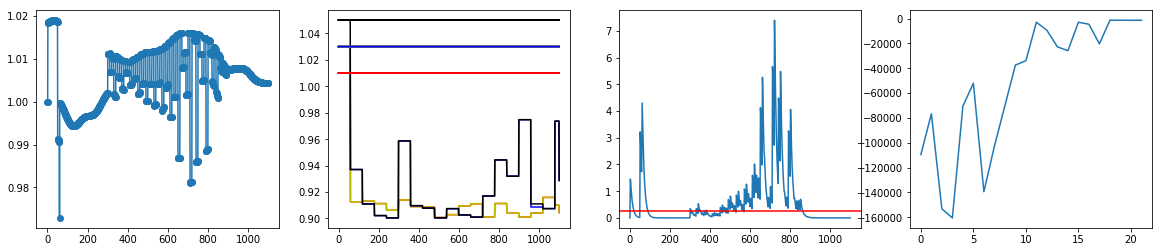

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03889346122741699 seconds ---
--- 0.042885541915893555 seconds ---
--- 0.03789639472961426 seconds ---
--- 0.04786849021911621 seconds ---
--- 0.04587578773498535 seconds ---
--- 0.04587602615356445 seconds ---
--- 0.04487895965576172 seconds ---
--- 0.03789782524108887 seconds ---
--- 0.03889274597167969 seconds ---
--- 0.050862789154052734 seconds ---
--- 0.04886913299560547 seconds ---
--- 0.03989386558532715 seconds ---
--- 0.04288339614868164 seconds ---
--- 0.04188799858093262 seconds ---
--- 0.04089045524597168 seconds ---
--- 0.04188704490661621 seconds ---
--- 0.04288530349731445 seconds ---
--- 0.03989243507385254 seconds ---
--- 0.05385541915893555 seconds ---
-1290.7777886848748
--- 60.88712191581726 seconds ---


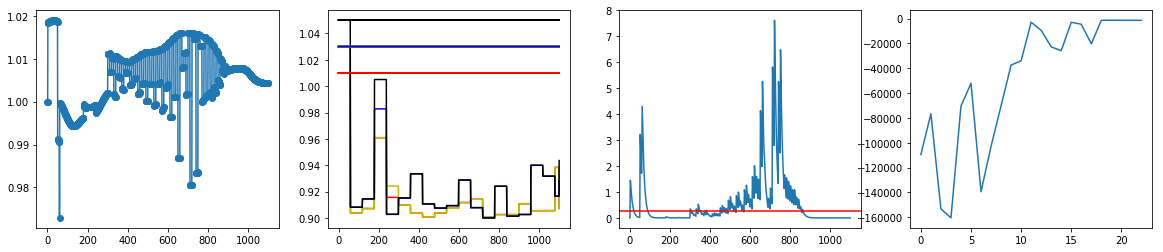

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04089021682739258 seconds ---
--- 0.03989219665527344 seconds ---
--- 0.04886674880981445 seconds ---
--- 0.04787015914916992 seconds ---
--- 0.048868417739868164 seconds ---
--- 0.04088926315307617 seconds ---
--- 0.038893938064575195 seconds ---
--- 0.04288482666015625 seconds ---
--- 0.04587674140930176 seconds ---
--- 0.04188799858093262 seconds ---
--- 0.04587674140930176 seconds ---
--- 0.039893150329589844 seconds ---
--- 0.041886329650878906 seconds ---
--- 0.049866437911987305 seconds ---
--- 0.03789973258972168 seconds ---
--- 0.044881343841552734 seconds ---
--- 0.047872066497802734 seconds ---
--- 0.04388022422790527 seconds ---
--- 0.04089045524597168 seconds ---
-1290.7777886848748
--- 61.54935145378113 seconds ---


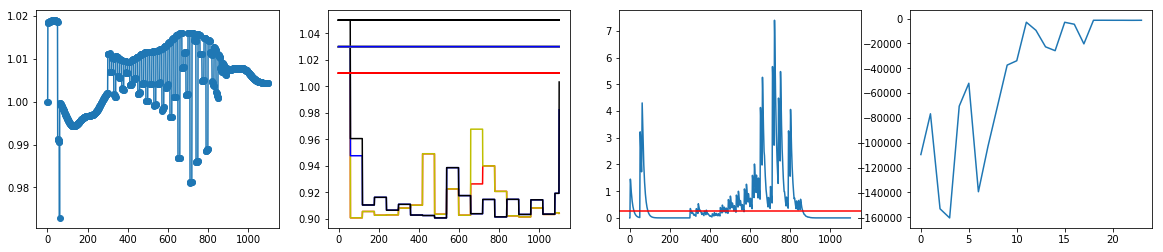

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.047870635986328125 seconds ---
--- 0.04188799858093262 seconds ---
--- 0.05186128616333008 seconds ---
--- 0.04088997840881348 seconds ---
--- 0.03889608383178711 seconds ---
--- 0.04388117790222168 seconds ---
--- 0.05086350440979004 seconds ---
--- 0.04387950897216797 seconds ---
--- 0.05784010887145996 seconds ---
--- 0.04088926315307617 seconds ---
--- 0.04787087440490723 seconds ---
--- 0.06183338165283203 seconds ---
--- 0.04388022422790527 seconds ---
--- 0.05485272407531738 seconds ---
--- 0.041887521743774414 seconds ---
--- 0.04288125038146973 seconds ---
--- 0.04786992073059082 seconds ---
--- 0.03989243507385254 seconds ---
--- 0.04089021682739258 seconds ---
-1290.7777886848748
--- 60.84323740005493 seconds ---


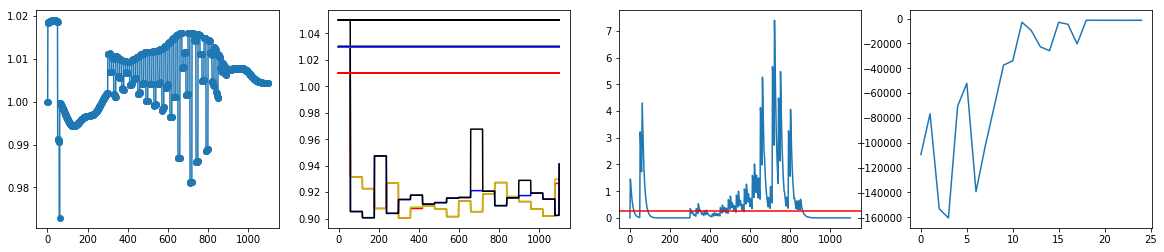

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.05186128616333008 seconds ---
--- 0.03988981246948242 seconds ---
--- 0.04787135124206543 seconds ---
--- 0.039891958236694336 seconds ---
--- 0.0418858528137207 seconds ---
--- 0.038895368576049805 seconds ---
--- 0.0498659610748291 seconds ---
--- 0.039893150329589844 seconds ---
--- 0.05086207389831543 seconds ---
--- 0.040889739990234375 seconds ---
--- 0.04886770248413086 seconds ---
--- 0.05385231971740723 seconds ---
--- 0.056845903396606445 seconds ---
--- 0.05485272407531738 seconds ---
--- 0.043882131576538086 seconds ---
--- 0.04587578773498535 seconds ---
--- 0.04388165473937988 seconds ---
--- 0.049866676330566406 seconds ---
--- 0.049866437911987305 seconds ---
-1290.7777886848748
--- 58.360880613327026 seconds ---


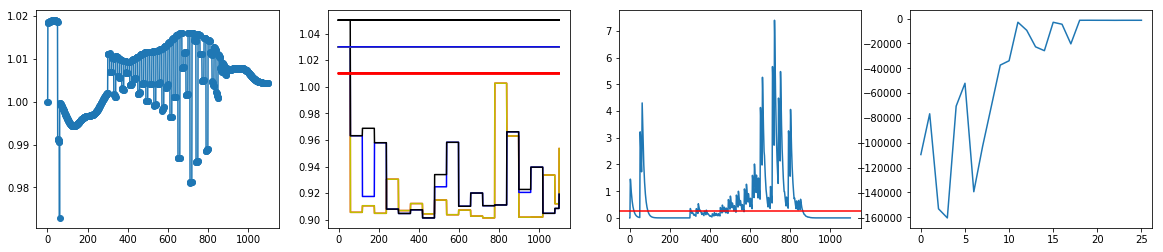

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04288339614868164 seconds ---
--- 0.04886674880981445 seconds ---
--- 0.04487752914428711 seconds ---
--- 0.041887760162353516 seconds ---
--- 0.053854942321777344 seconds ---
--- 0.037899017333984375 seconds ---
--- 0.04886579513549805 seconds ---
--- 0.04787325859069824 seconds ---
--- 0.038893699645996094 seconds ---
--- 0.053855180740356445 seconds ---
--- 0.045876502990722656 seconds ---
--- 0.04089164733886719 seconds ---
--- 0.038892269134521484 seconds ---
--- 0.04886817932128906 seconds ---
--- 0.04088902473449707 seconds ---
--- 0.04188704490661621 seconds ---
--- 0.043882131576538086 seconds ---
--- 0.049866676330566406 seconds ---
--- 0.03789567947387695 seconds ---
-1290.7777886848748
--- 62.32128548622131 seconds ---


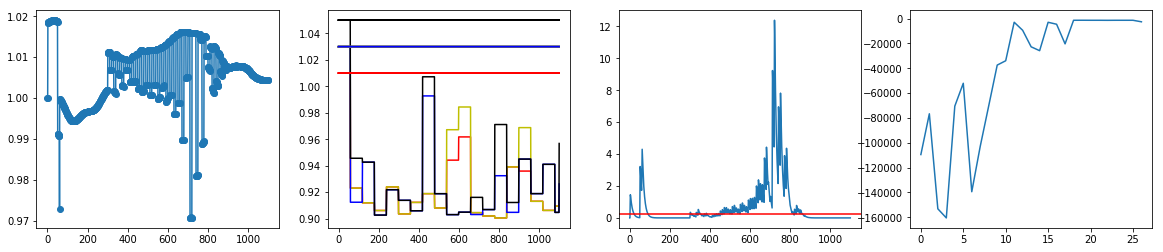

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03690052032470703 seconds ---
--- 0.04487895965576172 seconds ---
--- 0.048868417739868164 seconds ---
--- 0.045876502990722656 seconds ---
--- 0.040889739990234375 seconds ---
--- 0.03789782524108887 seconds ---
--- 0.0468745231628418 seconds ---
--- 0.04587602615356445 seconds ---
--- 0.04088997840881348 seconds ---
--- 0.045876264572143555 seconds ---
--- 0.046872615814208984 seconds ---
--- 0.03889584541320801 seconds ---
--- 0.04188728332519531 seconds ---
--- 0.04487895965576172 seconds ---
--- 0.04587268829345703 seconds ---
--- 0.03989243507385254 seconds ---
--- 0.04288458824157715 seconds ---
--- 0.04388284683227539 seconds ---
--- 0.05584979057312012 seconds ---
-1290.7777886848748
--- 58.86054253578186 seconds ---


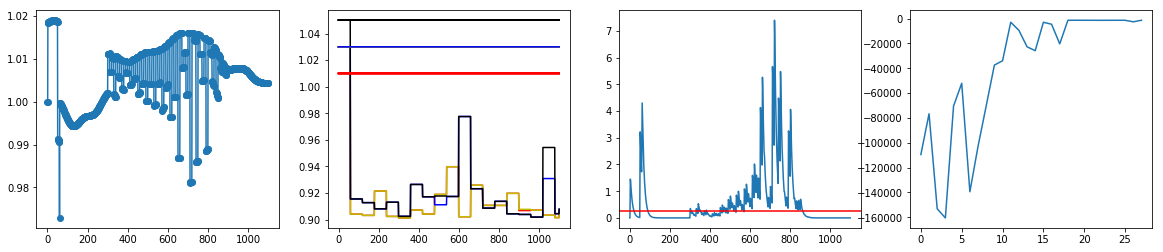

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04088783264160156 seconds ---
--- 0.0418851375579834 seconds ---
--- 0.041886091232299805 seconds ---
--- 0.03789830207824707 seconds ---
--- 0.038895368576049805 seconds ---
--- 0.047868967056274414 seconds ---
--- 0.0608363151550293 seconds ---
--- 0.045874595642089844 seconds ---
--- 0.04687070846557617 seconds ---
--- 0.04089069366455078 seconds ---
--- 0.05983877182006836 seconds ---
--- 0.04088711738586426 seconds ---
--- 0.053856849670410156 seconds ---
--- 0.05684638023376465 seconds ---
--- 0.0388951301574707 seconds ---
--- 0.04787111282348633 seconds ---
--- 0.04088711738586426 seconds ---
--- 0.04487895965576172 seconds ---
--- 0.03989291191101074 seconds ---
-1029.0789765779402
--- 58.37982797622681 seconds ---


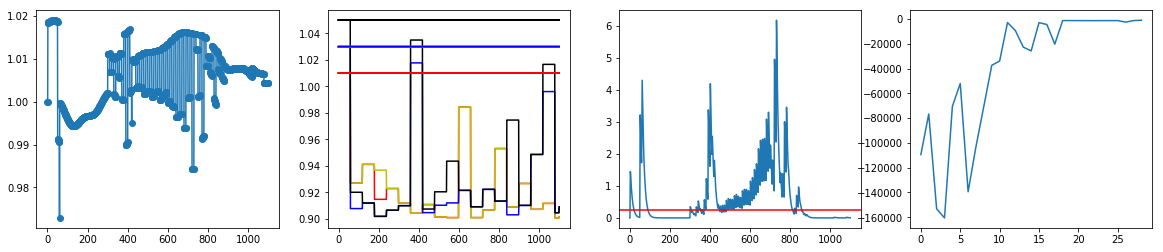

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03888702392578125 seconds ---
--- 0.040889739990234375 seconds ---
--- 0.04188823699951172 seconds ---
--- 0.04388260841369629 seconds ---
--- 0.04288220405578613 seconds ---
--- 0.04687333106994629 seconds ---
--- 0.040889739990234375 seconds ---
--- 0.04288482666015625 seconds ---
--- 0.044878482818603516 seconds ---
--- 0.05485391616821289 seconds ---
--- 0.044878482818603516 seconds ---
--- 0.04288458824157715 seconds ---
--- 0.04587531089782715 seconds ---
--- 0.04487800598144531 seconds ---
--- 0.043882131576538086 seconds ---
--- 0.04487943649291992 seconds ---
--- 0.042883872985839844 seconds ---
--- 0.04388165473937988 seconds ---
--- 0.05385565757751465 seconds ---
-1029.0789765779402
--- 69.69655752182007 seconds ---


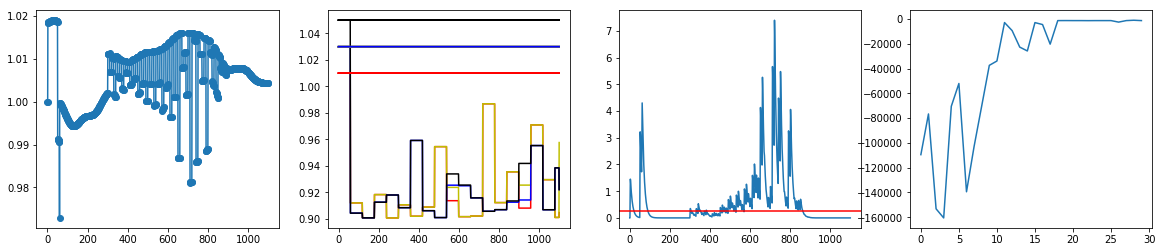

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04587817192077637 seconds ---
--- 0.045873403549194336 seconds ---
--- 0.03889632225036621 seconds ---
--- 0.05185866355895996 seconds ---
--- 0.03689932823181152 seconds ---
--- 0.042884111404418945 seconds ---
--- 0.04188680648803711 seconds ---
--- 0.04188680648803711 seconds ---
--- 0.0388948917388916 seconds ---
--- 0.046859025955200195 seconds ---
--- 0.031239748001098633 seconds ---
--- 0.05684852600097656 seconds ---
--- 0.045877933502197266 seconds ---
--- 0.05485248565673828 seconds ---
--- 0.040889739990234375 seconds ---
--- 0.05086255073547363 seconds ---
--- 0.04687333106994629 seconds ---
--- 0.04388141632080078 seconds ---
--- 0.03988170623779297 seconds ---
-1029.0789765779402
--- 66.80834150314331 seconds ---


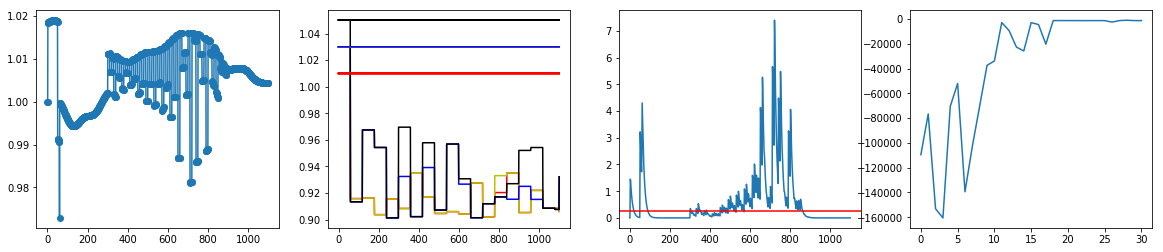

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.031244277954101562 seconds ---
--- 0.041884660720825195 seconds ---
--- 0.04686307907104492 seconds ---
--- 0.03889322280883789 seconds ---
--- 0.044877052307128906 seconds ---
--- 0.04686594009399414 seconds ---
--- 0.03989076614379883 seconds ---
--- 0.04686236381530762 seconds ---
--- 0.031241655349731445 seconds ---
--- 0.04686117172241211 seconds ---
--- 0.051859140396118164 seconds ---
--- 0.0624842643737793 seconds ---
--- 0.046864986419677734 seconds ---
--- 0.06248307228088379 seconds ---
--- 0.05186128616333008 seconds ---
--- 0.03989291191101074 seconds ---
--- 0.04188823699951172 seconds ---
--- 0.0498654842376709 seconds ---
--- 0.06248021125793457 seconds ---
-1029.0789765779402
--- 54.10572624206543 seconds ---


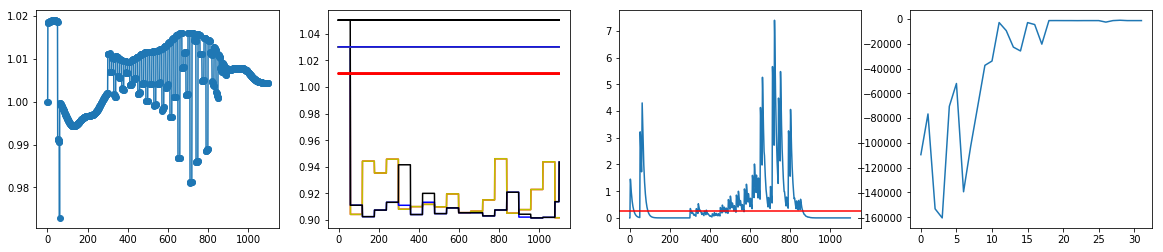

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04686331748962402 seconds ---
--- 0.04088902473449707 seconds ---
--- 0.059839487075805664 seconds ---
--- 0.03989267349243164 seconds ---
--- 0.031243562698364258 seconds ---
--- 0.031240463256835938 seconds ---
--- 0.04188680648803711 seconds ---
--- 0.046865224838256836 seconds ---
--- 0.04686427116394043 seconds ---
--- 0.04686880111694336 seconds ---
--- 0.031243085861206055 seconds ---
--- 0.031243562698364258 seconds ---
--- 0.06248641014099121 seconds ---
--- 0.05485177040100098 seconds ---
--- 0.04686236381530762 seconds ---
--- 0.04686164855957031 seconds ---
--- 0.04686450958251953 seconds ---
--- 0.062483787536621094 seconds ---
--- 0.04786944389343262 seconds ---
-1029.0789765779402
--- 57.92492723464966 seconds ---


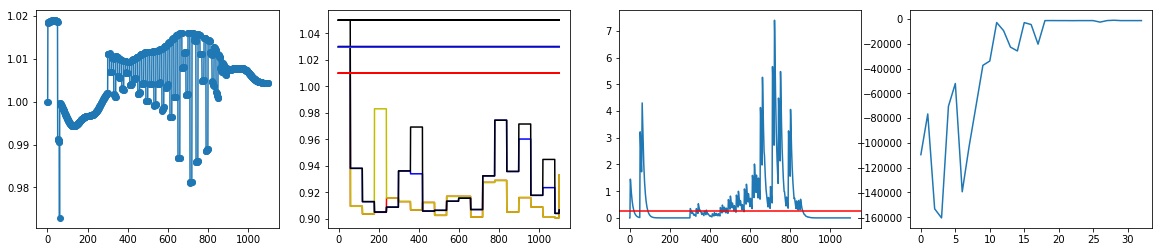

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04686737060546875 seconds ---
--- 0.04487872123718262 seconds ---
--- 0.03124213218688965 seconds ---
--- 0.04587554931640625 seconds ---
--- 0.0388944149017334 seconds ---
--- 0.05385422706604004 seconds ---
--- 0.048868417739868164 seconds ---
--- 0.04686260223388672 seconds ---
--- 0.04088854789733887 seconds ---
--- 0.042885541915893555 seconds ---
--- 0.0448765754699707 seconds ---
--- 0.05684781074523926 seconds ---
--- 0.04686284065246582 seconds ---
--- 0.04288458824157715 seconds ---
--- 0.04686570167541504 seconds ---
--- 0.04787015914916992 seconds ---
--- 0.031240463256835938 seconds ---
--- 0.04686594009399414 seconds ---
--- 0.03124260902404785 seconds ---
-1029.0789765779402
--- 58.054317474365234 seconds ---


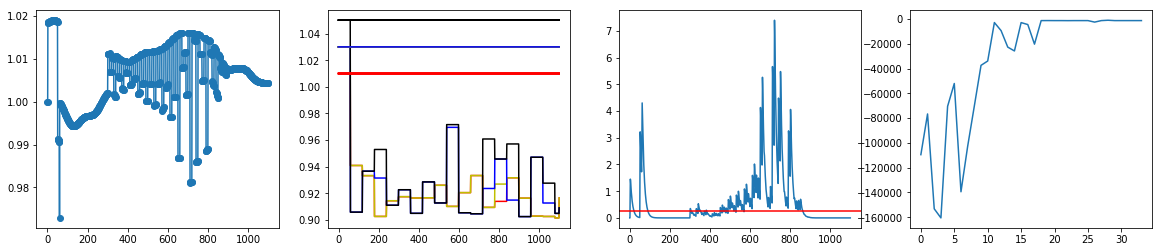

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04686474800109863 seconds ---
--- 0.0468595027923584 seconds ---
--- 0.04686093330383301 seconds ---
--- 0.04686331748962402 seconds ---
--- 0.038893938064575195 seconds ---
--- 0.031240463256835938 seconds ---
--- 0.04686617851257324 seconds ---
--- 0.0624849796295166 seconds ---
--- 0.031244993209838867 seconds ---
--- 0.046864986419677734 seconds ---
--- 0.05433773994445801 seconds ---
--- 0.0468602180480957 seconds ---
--- 0.04487943649291992 seconds ---
--- 0.04686379432678223 seconds ---
--- 0.062485456466674805 seconds ---
--- 0.03124094009399414 seconds ---
--- 0.031242847442626953 seconds ---
--- 0.038895368576049805 seconds ---
--- 0.0468599796295166 seconds ---
-1029.0789765779402
--- 54.362460136413574 seconds ---


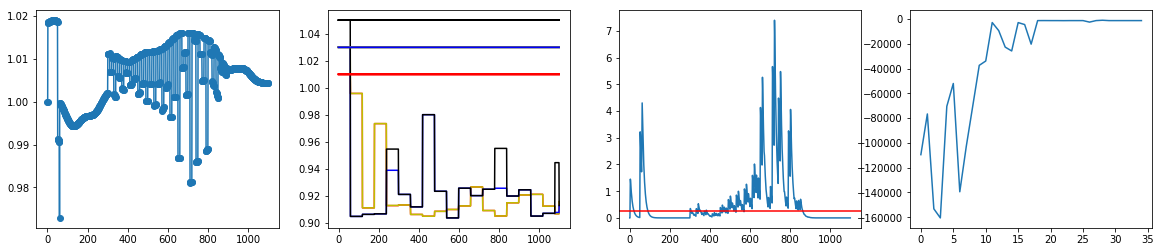

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03123927116394043 seconds ---
--- 0.0624852180480957 seconds ---
--- 0.031240463256835938 seconds ---
--- 0.0468599796295166 seconds ---
--- 0.04089164733886719 seconds ---
--- 0.046866655349731445 seconds ---
--- 0.04188418388366699 seconds ---
--- 0.04089021682739258 seconds ---
--- 0.03989267349243164 seconds ---
--- 0.03989124298095703 seconds ---
--- 0.05684685707092285 seconds ---
--- 0.03989148139953613 seconds ---
--- 0.043882131576538086 seconds ---
--- 0.04288601875305176 seconds ---
--- 0.04188394546508789 seconds ---
--- 0.03988981246948242 seconds ---
--- 0.040888309478759766 seconds ---
--- 0.04686331748962402 seconds ---
--- 0.0468752384185791 seconds ---
-1029.0789765779402
--- 58.903284311294556 seconds ---


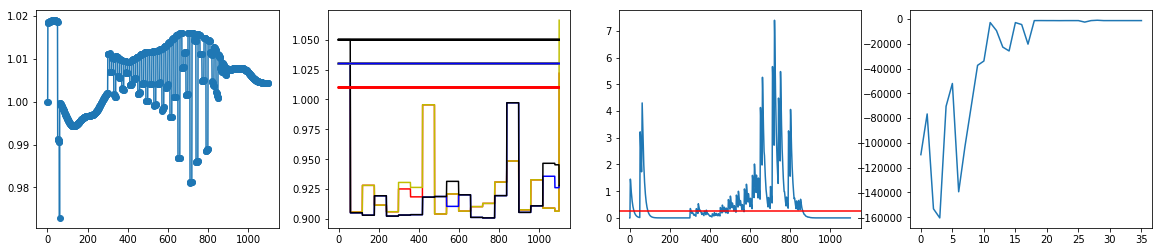

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03989291191101074 seconds ---
--- 0.052855491638183594 seconds ---
--- 0.04686403274536133 seconds ---
--- 0.04044318199157715 seconds ---
--- 0.031243324279785156 seconds ---
--- 0.03789567947387695 seconds ---
--- 0.046864986419677734 seconds ---
--- 0.03989434242248535 seconds ---
--- 0.03124690055847168 seconds ---
--- 0.03989243507385254 seconds ---
--- 0.046828508377075195 seconds ---
--- 0.04686856269836426 seconds ---
--- 0.03690052032470703 seconds ---
--- 0.045851945877075195 seconds ---
--- 0.031244993209838867 seconds ---
--- 0.037897586822509766 seconds ---
--- 0.04686617851257324 seconds ---
--- 0.038895368576049805 seconds ---
--- 0.031241178512573242 seconds ---
-1029.0789765779402
--- 51.125834226608276 seconds ---


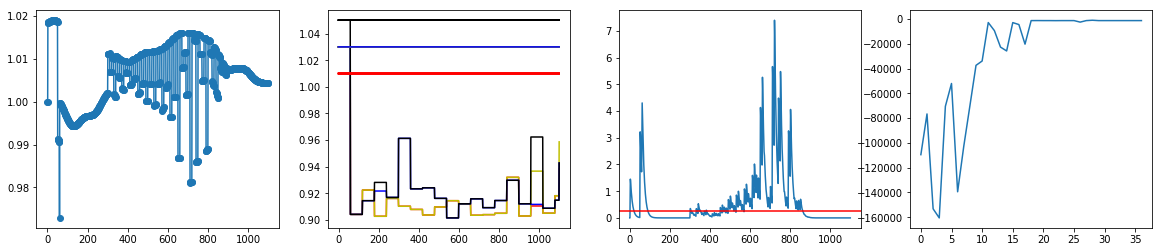

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.031244993209838867 seconds ---
--- 0.04686856269836426 seconds ---
--- 0.031242847442626953 seconds ---
--- 0.04686474800109863 seconds ---
--- 0.03789949417114258 seconds ---
--- 0.037897586822509766 seconds ---
--- 0.06068682670593262 seconds ---
--- 0.031243085861206055 seconds ---
--- 0.03789854049682617 seconds ---
--- 0.038896799087524414 seconds ---
--- 0.046865224838256836 seconds ---
--- 0.038897037506103516 seconds ---
--- 0.04387974739074707 seconds ---
--- 0.031246423721313477 seconds ---
--- 0.039891719818115234 seconds ---
--- 0.046865224838256836 seconds ---
--- 0.04587602615356445 seconds ---
--- 0.04686284065246582 seconds ---
--- 0.03990483283996582 seconds ---
-1029.0789765779402
--- 47.53354740142822 seconds ---


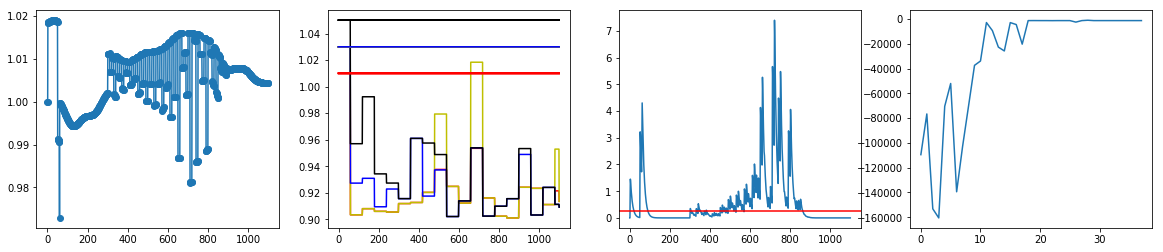

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.031243562698364258 seconds ---
--- 0.03889727592468262 seconds ---
--- 0.0388946533203125 seconds ---
--- 0.031247377395629883 seconds ---
--- 0.04686594009399414 seconds ---
--- 0.0388941764831543 seconds ---
--- 0.031241178512573242 seconds ---
--- 0.031246185302734375 seconds ---
--- 0.037897348403930664 seconds ---
--- 0.03124260902404785 seconds ---
--- 0.03889656066894531 seconds ---
--- 0.0388944149017334 seconds ---
--- 0.0468747615814209 seconds ---
--- 0.04686784744262695 seconds ---
--- 0.04088926315307617 seconds ---
--- 0.046866416931152344 seconds ---
--- 0.04854869842529297 seconds ---
--- 0.04188847541809082 seconds ---
--- 0.055023193359375 seconds ---
-1029.0789765779402
--- 47.77520227432251 seconds ---


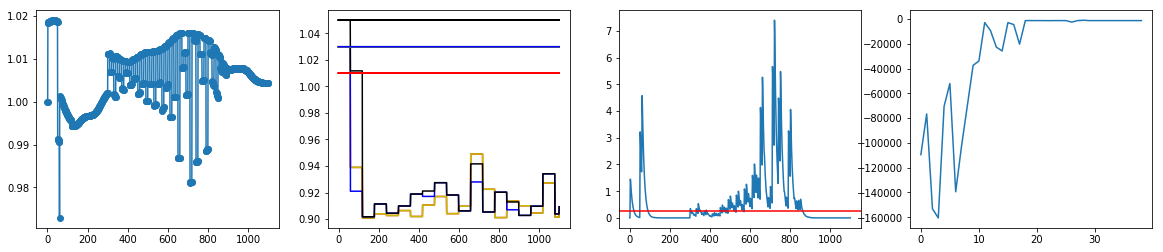

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.044213056564331055 seconds ---
--- 0.03124237060546875 seconds ---
--- 0.03891706466674805 seconds ---
--- 0.031241416931152344 seconds ---
--- 0.03888535499572754 seconds ---
--- 0.031240463256835938 seconds ---
--- 0.04686141014099121 seconds ---
--- 0.05065107345581055 seconds ---
--- 0.03689885139465332 seconds ---
--- 0.031246423721313477 seconds ---
--- 0.05103778839111328 seconds ---
--- 0.040889739990234375 seconds ---
--- 0.043882131576538086 seconds ---
--- 0.04587697982788086 seconds ---
--- 0.03889656066894531 seconds ---
--- 0.04686307907104492 seconds ---
--- 0.04587578773498535 seconds ---
--- 0.04686856269836426 seconds ---
--- 0.04188704490661621 seconds ---
-1029.0789765779402
--- 51.030396461486816 seconds ---


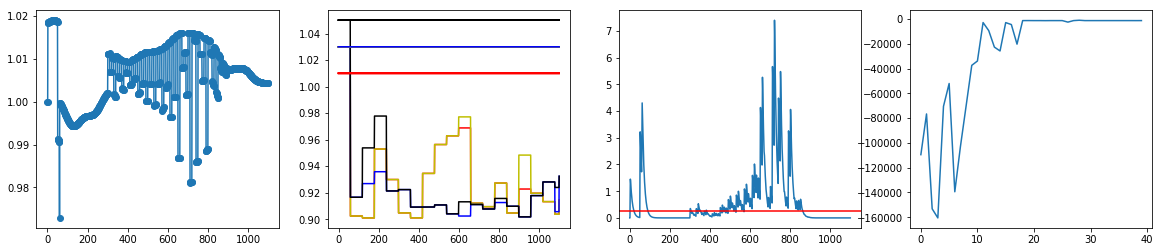

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04587602615356445 seconds ---
--- 0.04986119270324707 seconds ---
--- 0.03124547004699707 seconds ---
--- 0.04188680648803711 seconds ---
--- 0.04088783264160156 seconds ---
--- 0.04487752914428711 seconds ---
--- 0.03989005088806152 seconds ---
--- 0.031243562698364258 seconds ---
--- 0.03889656066894531 seconds ---
--- 0.03989458084106445 seconds ---
--- 0.045873403549194336 seconds ---
--- 0.042883872985839844 seconds ---
--- 0.03777480125427246 seconds ---
--- 0.031242847442626953 seconds ---
--- 0.038895606994628906 seconds ---
--- 0.031246662139892578 seconds ---
--- 0.04089021682739258 seconds ---
--- 0.04188084602355957 seconds ---
--- 0.04587674140930176 seconds ---
-1029.0789765779402
--- 57.07387042045593 seconds ---


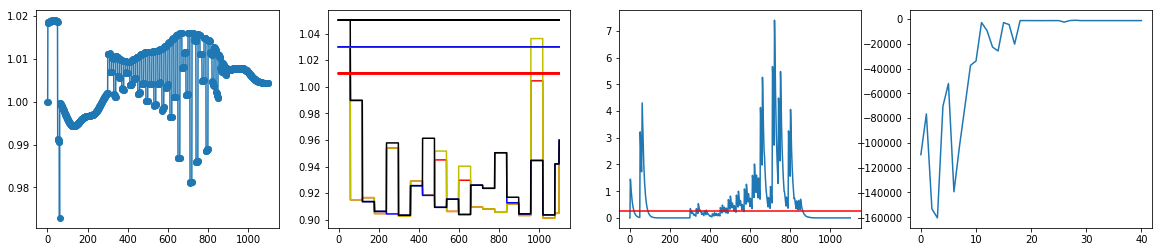

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03789782524108887 seconds ---
--- 0.0388951301574707 seconds ---
--- 0.039891719818115234 seconds ---
--- 0.04288506507873535 seconds ---
--- 0.04686260223388672 seconds ---
--- 0.04288363456726074 seconds ---
--- 0.03989410400390625 seconds ---
--- 0.040892839431762695 seconds ---
--- 0.03644299507141113 seconds ---
--- 0.0388946533203125 seconds ---
--- 0.03689908981323242 seconds ---
--- 0.031244754791259766 seconds ---
--- 0.05285835266113281 seconds ---
--- 0.04388117790222168 seconds ---
--- 0.04686594009399414 seconds ---
--- 0.031246423721313477 seconds ---
--- 0.042886972427368164 seconds ---
--- 0.039891958236694336 seconds ---
--- 0.031244277954101562 seconds ---
-1029.0789765779402
--- 55.86575508117676 seconds ---


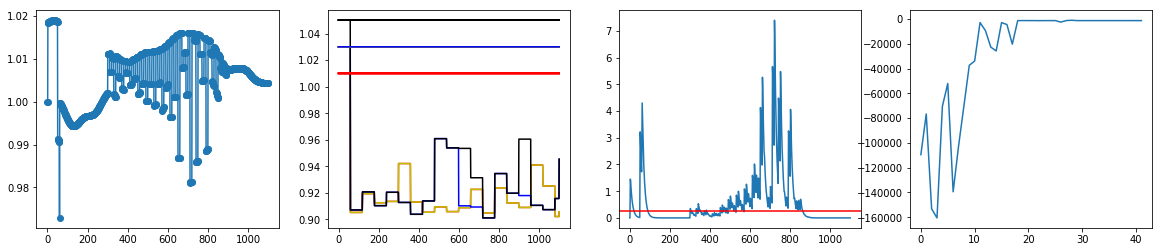

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04089045524597168 seconds ---
--- 0.0418848991394043 seconds ---
--- 0.05426764488220215 seconds ---
--- 0.03789782524108887 seconds ---
--- 0.06382346153259277 seconds ---
--- 0.031240463256835938 seconds ---
--- 0.04089021682739258 seconds ---
--- 0.046590566635131836 seconds ---
--- 0.03124523162841797 seconds ---
--- 0.04088783264160156 seconds ---
--- 0.045876264572143555 seconds ---
--- 0.031244993209838867 seconds ---
--- 0.062486886978149414 seconds ---
--- 0.04686379432678223 seconds ---
--- 0.03124403953552246 seconds ---
--- 0.04487919807434082 seconds ---
--- 0.03124523162841797 seconds ---
--- 0.043881893157958984 seconds ---
--- 0.05086398124694824 seconds ---
-1029.0789765779402
--- 59.75776028633118 seconds ---


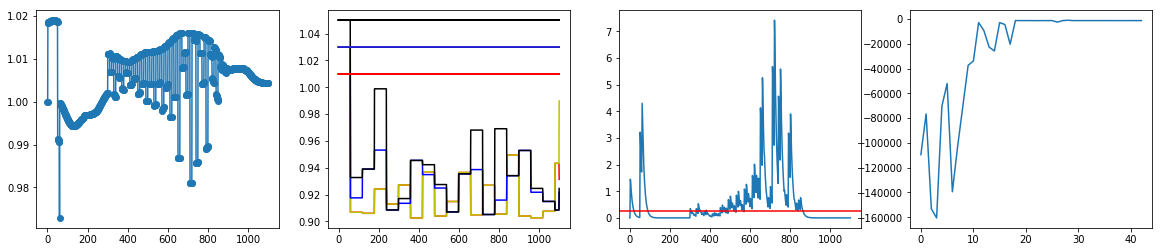

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.050862789154052734 seconds ---
--- 0.03989219665527344 seconds ---
--- 0.03989291191101074 seconds ---
--- 0.041887521743774414 seconds ---
--- 0.038895606994628906 seconds ---
--- 0.04686403274536133 seconds ---
--- 0.03124403953552246 seconds ---
--- 0.04686260223388672 seconds ---
--- 0.0468597412109375 seconds ---
--- 0.04787087440490723 seconds ---
--- 0.04686594009399414 seconds ---
--- 0.039891719818115234 seconds ---
--- 0.04188728332519531 seconds ---
--- 0.046859025955200195 seconds ---
--- 0.03124547004699707 seconds ---
--- 0.031242847442626953 seconds ---
--- 0.04686594009399414 seconds ---
--- 0.046861886978149414 seconds ---
--- 0.031244277954101562 seconds ---
-1029.0789765779402
--- 59.50415563583374 seconds ---


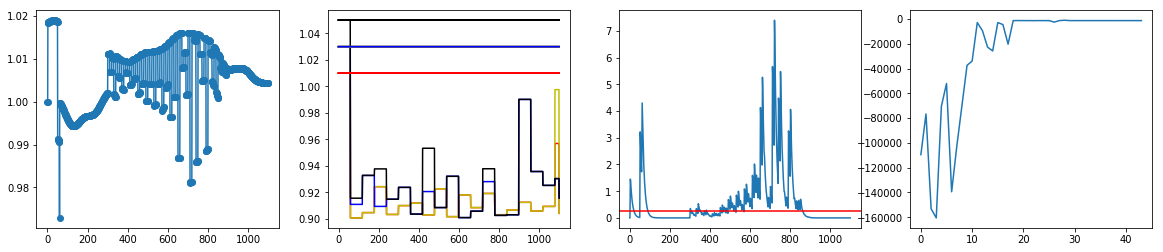

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.04088759422302246 seconds ---
--- 0.04986691474914551 seconds ---
--- 0.046866655349731445 seconds ---
--- 0.038515329360961914 seconds ---
--- 0.031243562698364258 seconds ---
--- 0.046863555908203125 seconds ---
--- 0.04587554931640625 seconds ---
--- 0.04587721824645996 seconds ---
--- 0.04188823699951172 seconds ---
--- 0.040891408920288086 seconds ---
--- 0.0388948917388916 seconds ---
--- 0.04088878631591797 seconds ---
--- 0.03124403953552246 seconds ---
--- 0.04686164855957031 seconds ---
--- 0.031245708465576172 seconds ---
--- 0.04686713218688965 seconds ---
--- 0.04686427116394043 seconds ---
--- 0.041884660720825195 seconds ---
--- 0.05784440040588379 seconds ---
-1029.0789765779402
--- 55.301177740097046 seconds ---


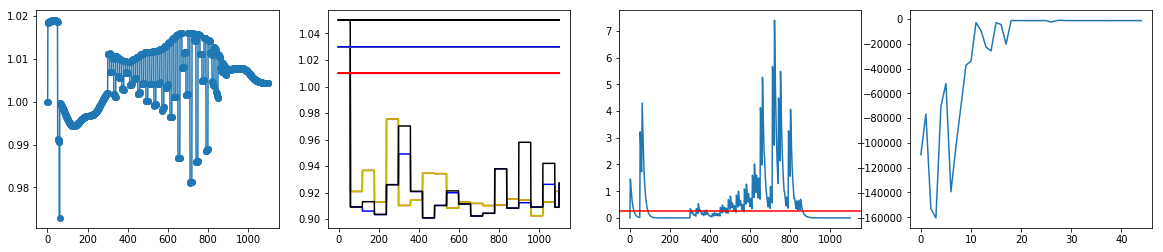

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.06682062149047852 seconds ---
--- 0.03989291191101074 seconds ---
--- 0.04686617851257324 seconds ---
--- 0.04686594009399414 seconds ---
--- 0.031244277954101562 seconds ---
--- 0.051857948303222656 seconds ---
--- 0.04587721824645996 seconds ---
--- 0.04686379432678223 seconds ---
--- 0.04388260841369629 seconds ---
--- 0.04686617851257324 seconds ---
--- 0.04487872123718262 seconds ---
--- 0.04288458824157715 seconds ---
--- 0.031247377395629883 seconds ---
--- 0.04986572265625 seconds ---
--- 0.0448756217956543 seconds ---
--- 0.031244516372680664 seconds ---
--- 0.03889322280883789 seconds ---
--- 0.06248188018798828 seconds ---
--- 0.04686594009399414 seconds ---
-1029.0789765779402
--- 59.916900634765625 seconds ---


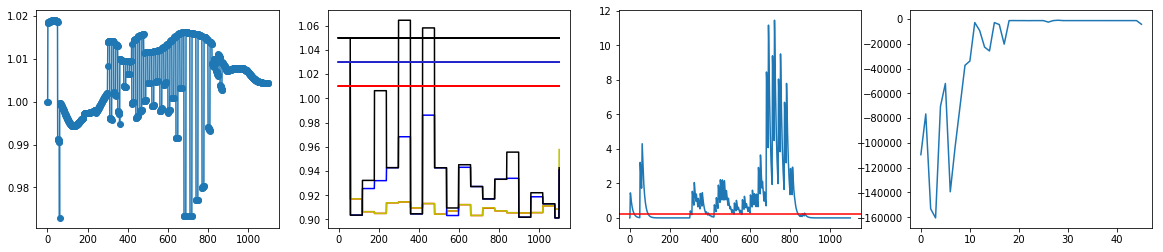

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.05186128616333008 seconds ---
--- 0.03124237060546875 seconds ---
--- 0.03889608383178711 seconds ---
--- 0.042883872985839844 seconds ---
--- 0.031240463256835938 seconds ---
--- 0.04686474800109863 seconds ---
--- 0.031243562698364258 seconds ---
--- 0.039895057678222656 seconds ---
--- 0.03690195083618164 seconds ---
--- 0.04683184623718262 seconds ---
--- 0.0388951301574707 seconds ---
--- 0.04758048057556152 seconds ---
--- 0.035901546478271484 seconds ---
--- 0.03689742088317871 seconds ---
--- 0.04683065414428711 seconds ---
--- 0.03786826133728027 seconds ---
--- 0.04182863235473633 seconds ---
--- 0.03789710998535156 seconds ---
--- 0.035904884338378906 seconds ---
-1029.0789765779402
--- 49.13943696022034 seconds ---


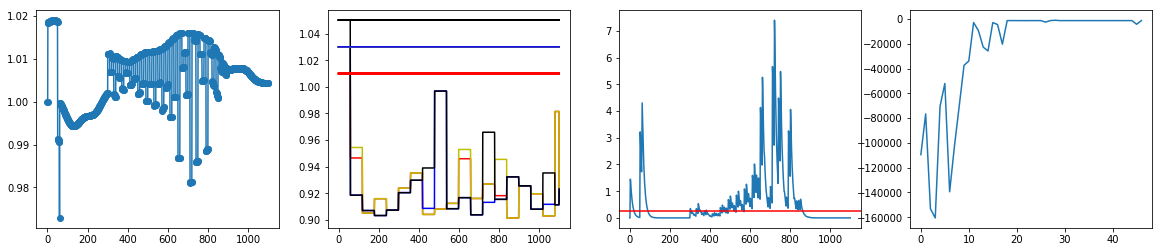

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.03786802291870117 seconds ---
--- 0.037895917892456055 seconds ---
--- 0.03789162635803223 seconds ---
--- 0.03686404228210449 seconds ---
--- 0.03124523162841797 seconds ---
--- 0.037899017333984375 seconds ---
--- 0.03927469253540039 seconds ---
--- 0.03889608383178711 seconds ---
--- 0.03789639472961426 seconds ---
--- 0.031214475631713867 seconds ---
--- 0.031215190887451172 seconds ---
--- 0.03895878791809082 seconds ---
--- 0.031244754791259766 seconds ---
--- 0.046828269958496094 seconds ---
--- 0.039887428283691406 seconds ---
--- 0.037897348403930664 seconds ---
--- 0.031207799911499023 seconds ---
--- 0.035872459411621094 seconds ---
--- 0.03789830207824707 seconds ---
-1029.0789765779402
--- 41.25342321395874 seconds ---


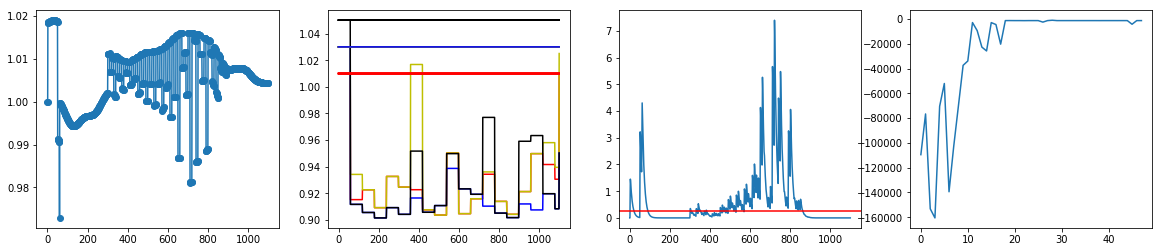

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.031247377395629883 seconds ---
--- 0.03690052032470703 seconds ---
--- 0.036900997161865234 seconds ---
--- 0.03914237022399902 seconds ---
--- 0.03689742088317871 seconds ---
--- 0.046866416931152344 seconds ---
--- 0.03789877891540527 seconds ---
--- 0.031215429306030273 seconds ---
--- 0.03789806365966797 seconds ---
--- 0.031247854232788086 seconds ---
--- 0.03786587715148926 seconds ---
--- 0.03346109390258789 seconds ---
--- 0.04686784744262695 seconds ---
--- 0.03124523162841797 seconds ---
--- 0.031245946884155273 seconds ---
--- 0.0359039306640625 seconds ---
--- 0.04686856269836426 seconds ---
--- 0.03789687156677246 seconds ---
--- 0.03789973258972168 seconds ---
-1029.0789765779402
--- 40.32337546348572 seconds ---


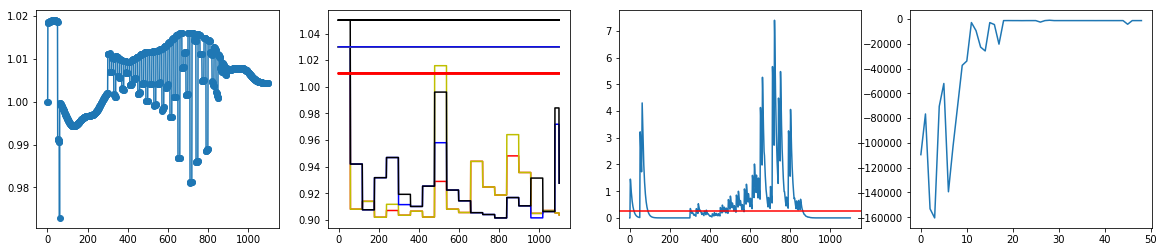

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
--- 0.033635854721069336 seconds ---
--- 0.049413442611694336 seconds ---
--- 0.0361628532409668 seconds ---
--- 0.03786778450012207 seconds ---
--- 0.03690171241760254 seconds ---
--- 0.046866655349731445 seconds ---
--- 0.03121495246887207 seconds ---
--- 0.03890800476074219 seconds ---
--- 0.03120732307434082 seconds ---
--- 0.03786420822143555 seconds ---
--- 0.036399126052856445 seconds ---
--- 0.04562067985534668 seconds ---
--- 0.037865400314331055 seconds ---
--- 0.03590202331542969 seconds ---
--- 0.031212806701660156 seconds ---
--- 0.031247377395629883 seconds ---
--- 0.03689932823181152 seconds ---
--- 0.031247377395629883 seconds ---
--- 0.03686785697937012 seconds ---
-1029.0789765779402
--- 41.049622535705566 seconds ---


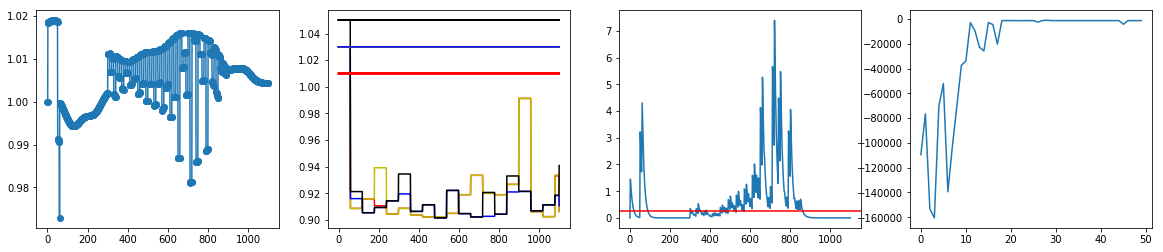

In [8]:
totalPoints = [[],[],[],[],[],[],[],[],[],[],[],[],[]]
############################################
########### INIT FOR AGENT #################
############################################

#init action
oldAction = []
action = []

#init state
oldState = []
state = []

#init reward
reward = None

mb_state=[]
mb_action=[]
mb_reward=[]
mb_nextstate=[]
buffer = ReplayBuffer(300)
BATCH_SIZE = 30

for ep in range(50):
    Load = Origin_Load.copy()
    Generation = Origin_Generation.copy()
    #this is for permutate the Load and Generation profile on each node
    #Load = np.random.permutation(Load.T).T
    #Generation = np.random.permutation(Generation.T).T

    #this is to permutate the Load and Generation profile
    #temp = np.copy(Load[:, 0:Number_of_Inverters])
    #Load[:, 0:Number_of_Inverters] = Load[:, Number_of_Inverters:Number_of_Inverters*2]
    #Load[:, Number_of_Inverters:Number_of_Inverters*2] = temp
    #temp = np.copy(Generation[:, 0:Number_of_Inverters])
    #Generation[:, 0:Number_of_Inverters] = Generation[:, Number_of_Inverters:Number_of_Inverters*2]
    #Generation[:, Number_of_Inverters:Number_of_Inverters*2] = temp

    #Create noise vector
    Noise = np.empty([TotalTimeSteps, TotalLoads])
    for node in range(TotalLoads):
        Noise[:,node] = np.random.randn(TotalTimeSteps) 

    #Add noise to loads
    for node in range(TotalLoads):
        Load[:,node] = Load[:,node] + NoiseMultiplyer*Noise[:,node]

    if NoiseMultiplyer > 0:
        print('Load Interpolation has been done. Noise was added to the load profile.') 
    else:
        print('Load Interpolation has been done. No Noise was added to the load profile.') 

    MaxGenerationPossible = np.max(Generation, axis = 0)
    sbar = MaxGenerationPossible
    
    start_time = time.time()
    #########################################################
    ################### RESTART OPENDSS #####################
    #########################################################
    DSSStart = DSSStartup()
    DSSText =DSSStart['dsstext']
    DSSSolution = DSSStart['dsssolution']
    DSSCircuit = DSSStart['dsscircuit']
    DSSObj = DSSStart['dssobj']
    DSSMon = DSSCircuit.Monitors
    DSSText.command = 'Compile C:\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
    DSSSolution.Solve()
    if not DSSSolution.Converged:
        print('Initial Solution Not Converged. Check Model for Convergence')
    else:
        print('Initial Model Converged. Proceeding to Next Step.')
        #Doing this solve command is required for GridPV, that is why the monitors
        #go under a reset process
        DSSMon.ResetAll
        setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
        #Easy process to get all names and count of loads, a trick to avoid
        #some more lines of code
        TotalLoads=DSSCircuit.Loads.Count
        AllLoadNames=DSSCircuit.Loads.AllNames
        print('OpenDSS Model Compliation Done.')

    ############################################
    ############ INIT NODES ####################
    ############################################
    nodes = {}
    features = ['Voltage', 'Generation', 'P', 'Q']

    for i in range(len(AllLoadNames)):
        df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
        nodes[i] = df
        nodes[i].loc['Generation'] = Generation[:,i]
        nodes[i].loc['P'] = 0
        nodes[i].loc['Q'] = 0

    ################################################
    ############ INIT INVERTERS ####################
    ################################################
    inverters = {}
    features = ['VBP', 'FilterVoltage', 'Generation', 'sbar', 'P_inv', 'Q_inv' ,'counter', 'ime_output', 'ep_output', 'yk', 'upk','uqk']

    offset = 5
    numberofInverters = Number_of_Inverters

    for i in range(len(AllLoadNames)):
        inverters[i] = []
        if offset-1 < i < numberofInverters + offset:
            df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
            df.at['FilterVoltage', 0] = 0
            df.loc['Generation'] = Generation[:,i]
            df.loc['sbar'] = sbar[i]
            df.loc['counter'] = 0
            df.loc['ime_output'] = 0
            df.loc['ep_output'] = 0
            df.loc['yk'] = 0
            df.loc['P_inv'] = 0
            df.loc['Q_inv'] = 0
            df.loc['upk'] = 0
            df.loc['uqk'] = 0
            inverters[i].append(df)

    ############################################
    ########### INIT VBPCURVE ##################
    ############################################
    for i in range(len(AllLoadNames)):
        for j in range(len(inverters[i])):
            for k in range(TotalTimeSteps):
                inverters[i][j].at['VBP',k] = np.array([1.01, 1.03, 1.03, 1.05])

    VBPcounter = [0,0,0,0,0,0,0,0,0,0,0,0,0]

    controlInv = list(range(7,8))    
    points = [0,0,0,0,0,0,0,0,0,0,0,0,0]
    terminal = False
    
    for timeStep in range(TotalTimeSteps):
        VBPcounter = [x+1 for x in VBPcounter] 
        ####################################################
        ################ run the simulation ################
        ####################################################
        #for the first steps, we just init voltage value, no pq injection
        if timeStep == 0:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node]])
        else:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node] + nodes[node].at['P', timeStep-1]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node] + nodes[node].at['Q', timeStep-1]])

        DSSSolution.Solve()
        if (not DSSSolution.Converged):
            print('Solution Not Converged at Step:', timeStep)

        #get the voltage info
        nodeInfo = getLoadInfo(DSSObj, [])
        #distribute voltage to node
        for i in range(len(nodes)):
            node = nodes[i]
            node.at['Voltage', timeStep] = nodeInfo[i]['voltagePU']
            if timeStep == 0 or timeStep == 1:
                node.at['Voltage', timeStep] = 1
        #############################################################
        #############################################################
        #############################################################
        if timeStep == TimeStepOfHack:
            for node in range(len(AllLoadNames)):
                if inverters[node] != []:
                    inverter = inverters[node][0]
                    #create new inverter
                    hackedInv = copy.deepcopy(inverter)
                    for k in range(timeStep, TotalTimeSteps):
                        hackedInv.at['VBP',k] = np.array([1.01, 1.015, 1.015, 1.02])

                    hackedInv.loc['sbar'][timeStep:] = hackedInv.loc['sbar'][timeStep:]*PercentHacked[node]
                    hackedInv.loc['Generation'][timeStep:] = hackedInv.loc['Generation'][timeStep:]*PercentHacked[node]
                    inverters[node].append(hackedInv)
                    #generation and sbar change on the original inverter
                    inverter.loc['sbar'][timeStep:] = inverter.loc['sbar'][timeStep:]*(1-PercentHacked[node])
                    inverter.loc['Generation'][timeStep:] = inverter.loc['Generation'][timeStep:]*(1-PercentHacked[node])
        ########################################################################
        ########################################################################
        ########################################################################
        
        if timeStep == TotalTimeSteps-1:
            terminal = True
            
        if timeStep != 0:
            for node in range(len(AllLoadNames)):
                #if we have inverters at that node then...
                if inverters[node] != []:
                    invertersNode = inverters[node] #get the list of inverters at that node
                    for inverter in invertersNode: #get an inverter at that node
                        #increase the counter
                        inverter.at['counter',timeStep] = inverter.at['counter',timeStep-1] + 1
                        if inverter.at['counter',timeStep-1] == Delay_VoltageSampling[node]:
                            inverter.at['counter',timeStep] = 1
                            
                        #get State
                        if (node in controlInv) and (inverter is invertersNode[0]):
                            if VBPcounter[node-offset] == Delay_VBPCurveShift[node] or terminal == True:
                                if terminal == False:
                                    length = Delay_VBPCurveShift[node]
                                    V = nodes[node].loc['Voltage',timeStep-length+1:timeStep]
                                    G = inverter.loc['Generation', timeStep-length+1:timeStep] 
                                    L = Load[timeStep-length+1:timeStep+1, node]
                                else:
                                    length = VBPcounter[node-offset]
                                    V = nodes[node].loc['Voltage',timeStep-length+1:]
                                    G = inverter.loc['Generation', timeStep-length+1:]
                                    L = Load[timeStep-length+1:, node]
                                    
                                oldState = state
                                state = processing_state(V,G,L)
                                #reset VBPcounter
                                VBPcounter[node-offset] = 0
                                #store action                        
                                oldAction = copy.deepcopy(action)
                                
                                #get Action from Agent
                                action = agent.action_respond(state.reshape((1,60,3)))
                                #apply strict boundary
                                if action[1] < action[0]:
                                    action[0] = action[1]
                                if action[3] < action[2]:
                                    action[2] = action[3]
                                for k in range(timeStep, TotalTimeSteps):
                                    inverter.at['VBP',k] = copy.deepcopy(action*0.1 + 1)
                                
                                #reward
                                #caculate yk for that inverter
                                inverter.at['yk', timeStep], inverter.at['ime_output', timeStep], inverter.at['ep_output', timeStep] = voltage_observer(
                                         nodes[node].at['Voltage', timeStep], 
                                         nodes[node].at['Voltage', timeStep-1],
                                         inverter.at['ime_output', timeStep-1], 
                                         inverter.at['ep_output', timeStep-1], 
                                         inverter.at['yk', timeStep-1])

                                numberYks = inverter.loc['yk', timeStep-length+1:timeStep]
                                numberYks = numberYks - 0.25
                                numberYks = numberYks[numberYks > 0]
                                reward = - sum(numberYks**2)
                                
                                #sum of reward for that ep
                                points[node-offset] += reward
                                
                                
                                if oldAction != [] and oldState != []:
                                    if terminal: 
                                        ter = 1
                                    else:
                                        ter = 0
                                    buffer.add(oldState.reshape((60,3)), oldAction, np.array([reward]), np.array([ter]), state.reshape((60,3)))
                                
                                if buffer.size() > BATCH_SIZE:
                                    batch = {}
                                    mb_state, mb_action, mb_reward, mb_ter, mb_nextstate = buffer.sample_batch(BATCH_SIZE)
                                    batch['observations'] = mb_state
                                    batch['actions'] = mb_action
                                    batch['rewards'] = mb_reward
                                    batch['next_observations'] = mb_nextstate
                                    batch['rewards'] = mb_reward
                                    batch['terminals'] = mb_ter
                                    start_time_train = time.time()
                                    agent.do_training(batch)
                                    print("--- %s seconds ---" % (time.time() - start_time_train))
                        #################################################                        
                        #################################################
                        #execute action
                        inverter.at['Q_inv', timeStep], inverter.at['P_inv', timeStep], inverter.at['FilterVoltage', timeStep] = inverter_qp_injection(
                            inverter.at['counter',timeStep],
                            nodes[node].at['Voltage', timeStep],
                            nodes[node].at['Voltage', timeStep-1],
                            inverter.at['FilterVoltage', timeStep-1],
                            inverter.at['Generation', timeStep],
                            inverter.at['VBP', timeStep],
                            inverter.at['sbar', timeStep],
                            Delay_VoltageSampling[node])
                        
                        inverter.at['yk', timeStep], inverter.at['ime_output', timeStep], inverter.at['ep_output', timeStep] = voltage_observer(
                                         nodes[node].at['Voltage', timeStep], 
                                         nodes[node].at['Voltage', timeStep-1],
                                         inverter.at['ime_output', timeStep-1], 
                                         inverter.at['ep_output', timeStep-1], 
                                         inverter.at['yk', timeStep-1])

                        
                        
                        #caculate P Q injection at the node
                        nodes[node].at['P', timeStep] += inverter.at['P_inv', timeStep]
                        nodes[node].at['Q', timeStep] += inverter.at['Q_inv', timeStep]

    ######### drawing #####################
    
    for i in range(len(points)):
        totalPoints[i].append(points[i])
    print(max(totalPoints[7-offset]))
    print("--- %s seconds ---" % (time.time() - start_time))
    f = plt.figure()
    f.set_figheight(4)
    f.set_figwidth(20)
    f.add_subplot(1,4,1)
    plt.plot(nodes[7].loc['Voltage'], marker='o')
    
    for i in range(5,18):
        x = inverters[i][0].loc['VBP']
        y=np.zeros([len(x),x[0].shape[0]])
        for i in range(len(x)):
            y[i,:] = x[i]
        f.add_subplot(1,4,2)
        plt.plot(y[:,0], 'r')
        plt.plot(y[:,1], 'y')
        plt.plot(y[:,2], 'b')
        plt.plot(y[:,3], 'k')
    
    f.add_subplot(1,4,3)
    for i in range(7,8):
        yk = inverters[i][0].loc['yk']
        plt.plot(yk)
    plt.axhline(y=0.25, color='r', linestyle='-')
    f.add_subplot(1,4,4)
    plt.plot(totalPoints[7-offset])
    plt.show(block=True)
    f.savefig(str(ep) + '.png')
